# Capstone project, predicting song popularity

### Table of contents

- [Intro](#1-bullet)
- [Loading Data and checking for high-level details](#2-bullet)
- [Initial EDA](#3-bullet)
- [Feature Engineering](#6-bullet)
- [Prepping data for modeling](#4-bullet)
- [Linear Regression](#9-bullet)
- [Decision Tree Classifier](#5-bullet)
- [Random Forest](#8-bullet)
- [Models Results](#10-bullet)
- [Conclusion](#7-bullet)


### Intro<a class="anchor" id="1-bullet"></a>

In this project we will analyze a dataset containing features and characteristics of Spotify songs. We will do this in order to create accurate machine learning models that can predict the popularity of such songs. Record labels, artists and people in the music industry in general could benefit from the understainding of what makes a song popular.

We will try to understand what kind of features popular songs tend to have and create machine learning models to predict future songs' popularity. Could it be the artist name, the valence, the tempo, the danceability, the release date or a combination of these factors that will make the difference? We will use Data Science to find out.

### Loading Data and checking for high-level details<a class="anchor" id="2-bullet"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix, f1_score, roc_curve, auc


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [2]:
# This following code should import the first dataset

df = pd.read_csv('tracks.csv')

In [3]:
df.shape

(586672, 20)

Let's filter out any songs that are composed of only speech, any songs that have 0 popularity and any songs with 0 time signature. This should cut out noisy data and not skew our dataset

In [4]:
# the following code should filter out the noisy data

df = df[df['speechiness']<0.66]
df = df[df['popularity']>0]
df = df[df['time_signature']>0]

In [5]:
# Sanity check 

df.shape

(522483, 20)

Now, let's take a look at the columns and first 5 rows

In [6]:
# The following code should allow us to take a look at all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3
13,0QiT0Oo5QdLXdFw6RDOj7h,Tu Verras Montmartre,1,186800,0,['Lucien Boyer'],['4mSouLpNSEY1d7OdIjlFiP'],1922,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4
26,112adU33vo4C1eRZct2hWy,Nuits De Chine,4,180800,0,['Louis Lynel'],['28pbIiOohRRZjqpAM9iqYM'],1922,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3
149,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,41,177133,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4
150,3eMrYc092k7SIJfWJ7oasR,Weather Bird,38,161933,0,"['Louis Armstrong', 'Earl Hines']","['19eLuQmk9aCobbVDHc6eek', '2mY5u4CceAPrpBnse1...",1923,0.831,0.2620,8,-12.386,1,0.0942,0.984,0.912000,0.204,0.901,104.606,4


It appears we have some characters ([' ']) in our id_artist (our primary key) that we should cut out in order to merge with our second dataset.

For example, ['45tIt06XoI0Iio4LBEVpls'] should be 45tIt06XoI0Iio4LBEVpls in order to make it possible to join with our second dataset.

In [7]:
df['id_artists'] = [i[2:-2] for i in df['id_artists']]

In [8]:
# Let's see if our previous code worked

df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3
13,0QiT0Oo5QdLXdFw6RDOj7h,Tu Verras Montmartre,1,186800,0,['Lucien Boyer'],4mSouLpNSEY1d7OdIjlFiP,1922,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4
26,112adU33vo4C1eRZct2hWy,Nuits De Chine,4,180800,0,['Louis Lynel'],28pbIiOohRRZjqpAM9iqYM,1922,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3
149,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,41,177133,0,['Bessie Smith'],5ESobCkc6JI4tIMxQttqeg,1923,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4
150,3eMrYc092k7SIJfWJ7oasR,Weather Bird,38,161933,0,"['Louis Armstrong', 'Earl Hines']","19eLuQmk9aCobbVDHc6eek', '2mY5u4CceAPrpBnse1WpFr",1923,0.831,0.2620,8,-12.386,1,0.0942,0.984,0.912000,0.204,0.901,104.606,4


Now we will import our second dataset and join with our first dataset

In [9]:
# this code should read our second dataset

df1 = pd.read_csv('artists.csv')

In [10]:
df1.shape

(1162095, 5)

In [11]:
# Let's take a look at the second dataset

df1.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


It appears that "name", "popularity" and "id" can become a little bit confusing since we have similarly named columns in our first dataset. We should rename these columns to "id_artists", "artists_popularity" and "artist"

In [12]:
# We should rename our columns in our second dataset to merge id_artists and make them more straightforward

df1.rename(columns = {'id': 'id_artists','popularity': 'artists_popularity', 'name' :'artist'}, inplace = True)

In [13]:
# sanity check

df1.head()

,id_artists,followers,genres,artist,artists_popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


It appears we have some values that are empty in our "genres" column, let's investigate and see exactly how many.

In [14]:
# Len 2 should represent our empty values

len_val = df1['genres'].str.len()

len_val.value_counts()

2      856500
15      17974
17      17894
20      16657
16      16459
19      16031
18      15990
14      15055
21      12979
13      12313
22      11246
12      10264
23       9816
11       7713
24       7196
25       6444
10       6048
26       5904
9        5812
28       4683
29       4518
27       4513
32       3542
30       3501
33       3381
34       3201
31       3168
35       3151
36       2886
37       2542
39       2500
40       2482
8        2375
38       2326
42       2205
41       2181
43       1907
44       1709
45       1693
47       1477
46       1476
48       1395
49       1186
50       1123
7        1072
51       1050
53       1036
52       1029
56        993
55        987
54        982
57        878
58        854
59        813
61        811
60        735
62        645
63        591
64        587
65        581
66        579
67        557
68        536
71        486
70        481
73        475
72        466
69        449
74        407
75        384
76        374
79    

In [15]:
len_val.value_counts()/df1.shape[0]*100

2      73.703097
15      1.546689
17      1.539805
20      1.433360
16      1.416321
19      1.379491
18      1.375963
14      1.295505
21      1.116862
13      1.059552
22      0.967735
12      0.883232
23      0.844681
11      0.663715
24      0.619226
25      0.554516
10      0.520439
26      0.508048
9       0.500131
28      0.402979
29      0.388781
27      0.388350
32      0.304794
30      0.301266
33      0.290940
34      0.275451
31      0.272611
35      0.271148
36      0.248345
37      0.218743
39      0.215129
40      0.213580
8       0.204372
38      0.200156
42      0.189744
41      0.187678
43      0.164100
44      0.147062
45      0.145685
47      0.127098
46      0.127012
48      0.120042
49      0.102057
50      0.096636
7       0.092247
51      0.090354
53      0.089149
52      0.088547
56      0.085449
55      0.084933
54      0.084503
57      0.075553
58      0.073488
59      0.069960
61      0.069788
60      0.063248
62      0.055503
63      0.050856
64      0.0505

Since genres appears to be mostly empty (about 73% is empty values) we might as well drop this column. 

Also we already have the artist name under the artist column in our second dataset, we should drop this column as well.

In [16]:
# These codes should drop the columns we no longer need

df1 = df1.drop(columns='genres')
df = df.drop(columns='artists')

In [17]:
# Let's see if our change worked

df1.head()

,id_artists,followers,artist,artists_popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,Ioannis Panoutsopoulos,0


In [18]:
df.head()

,id,name,popularity,duration_ms,explicit,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3
13,0QiT0Oo5QdLXdFw6RDOj7h,Tu Verras Montmartre,1,186800,0,4mSouLpNSEY1d7OdIjlFiP,1922,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4
26,112adU33vo4C1eRZct2hWy,Nuits De Chine,4,180800,0,28pbIiOohRRZjqpAM9iqYM,1922,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3
149,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,41,177133,0,5ESobCkc6JI4tIMxQttqeg,1923,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4
150,3eMrYc092k7SIJfWJ7oasR,Weather Bird,38,161933,0,"19eLuQmk9aCobbVDHc6eek', '2mY5u4CceAPrpBnse1WpFr",1923,0.831,0.2620,8,-12.386,1,0.0942,0.984,0.912000,0.204,0.901,104.606,4


Great! it looks like we are ready to merge our two datasets into a new dataset

In [19]:
# This should merge our two datasets on our primary and foreign keys

df2 = df.merge(df1, on = 'id_artists')

In [20]:
# Let's see what our new dataset looks like

df2.head()

,id,name,popularity,duration_ms,explicit,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,Uli,4
1,0QiT0Oo5QdLXdFw6RDOj7h,Tu Verras Montmartre,1,186800,0,4mSouLpNSEY1d7OdIjlFiP,1922,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,Lucien Boyer,4
2,112adU33vo4C1eRZct2hWy,Nuits De Chine,4,180800,0,28pbIiOohRRZjqpAM9iqYM,1922,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,Louis Lynel,2
3,6zdtMcHb08xZ0AzvLU5s0x,Les ménétriers,2,149760,0,28pbIiOohRRZjqpAM9iqYM,1924,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.135,0.647,79.817,4,39.0,Louis Lynel,2
4,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,41,177133,0,5ESobCkc6JI4tIMxQttqeg,1923,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,Bessie Smith,44


 We might as well drop the id and id_artists column to make our dataset cleaner. Also we'll rename our name column to song_name to make it less confusing

In [21]:
# Drop repeated columns

df2 = df2.drop(columns='id')
df2 = df2.drop(columns='id_artists')

# Rename the column name

df2.rename(columns = {'name': 'song_name'}, inplace = True)

In [22]:
# Let's see what our clean dataset looks like

df2.head()

,song_name,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity
0,Carve,6,126903,0,1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,Uli,4
1,Tu Verras Montmartre,1,186800,0,1922,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,Lucien Boyer,4
2,Nuits De Chine,4,180800,0,1922,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,Louis Lynel,2
3,Les ménétriers,2,149760,0,1924,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.135,0.647,79.817,4,39.0,Louis Lynel,2
4,Nobody Knows You When You're Down and Out,41,177133,0,1923,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,Bessie Smith,44


We should now filter out artists with 0 popularity and 0 followers to not skew our data. There can be many artists with very low popularity and training our model on them might not be very useful to predict popularity.

In [23]:
df2 = df2[df2['artists_popularity']>0]
df2 = df2[df2['followers']>0]

In [24]:
# Now let's check the shape of our dataset

df2.shape

(427407, 20)

In [25]:
# Let's check and see if we have any null values

df2.isnull().sum()

song_name             0
popularity            0
duration_ms           0
explicit              0
release_date          0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
followers             0
artist                0
artists_popularity    0
dtype: int64

In [26]:
# Let's also take a look at the format our data is in

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427407 entries, 0 to 428044
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   song_name           427407 non-null  object 
 1   popularity          427407 non-null  int64  
 2   duration_ms         427407 non-null  int64  
 3   explicit            427407 non-null  int64  
 4   release_date        427407 non-null  object 
 5   danceability        427407 non-null  float64
 6   energy              427407 non-null  float64
 7   key                 427407 non-null  int64  
 8   loudness            427407 non-null  float64
 9   mode                427407 non-null  int64  
 10  speechiness         427407 non-null  float64
 11  acousticness        427407 non-null  float64
 12  instrumentalness    427407 non-null  float64
 13  liveness            427407 non-null  float64
 14  valence             427407 non-null  float64
 15  tempo               427407 non-nul

It seems our dataset is clean, but our release date is in "object" format and also our duration is in milliseconds. It should be easier to work with seconds and minutes as our duration metrics. 

For now let's change release date so we have release year, release month and release day. But first let's make sure the column contains years, months and days.

In [28]:
df['length'] = df['release_date'].str.len()

# create new column indicating whether value is full date or just year
df['type'] = df['length'].apply(lambda x: 'year' if x == 4 else 'date')

# count number of values of each type
counts = df['type'].value_counts()
print(counts)

date    409740
year    112743
Name: type, dtype: int64


It looks like we have 112743 values with just the release year but no release month or release day under release_date.

Since we have no null values creating a feature called release_year should still be a realiable tool, but release_day or release_month not, since we had so many values without this information.

In [29]:
# Let's change the Release_date to the datetime format

df2['release_date'] = pd.to_datetime(df2['release_date'], errors='coerce')

In [30]:
# Let's double check and see if our release date is now in datetime format

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427407 entries, 0 to 428044
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   song_name           427407 non-null  object        
 1   popularity          427407 non-null  int64         
 2   duration_ms         427407 non-null  int64         
 3   explicit            427407 non-null  int64         
 4   release_date        427407 non-null  datetime64[ns]
 5   danceability        427407 non-null  float64       
 6   energy              427407 non-null  float64       
 7   key                 427407 non-null  int64         
 8   loudness            427407 non-null  float64       
 9   mode                427407 non-null  int64         
 10  speechiness         427407 non-null  float64       
 11  acousticness        427407 non-null  float64       
 12  instrumentalness    427407 non-null  float64       
 13  liveness            427407 no

In [31]:
# Here we will convert the release date column to split it afterwards, so we can have release day, month and year


df2['release_date'] = df2['release_date'].astype(str)

In [32]:
#Here we will be splitting our previous column and we might as well drop the original one since we dont need it anymore

df2[['release_year', 'release_month', 'release_day']] = df2['release_date'].str.split('-', expand=True)

df2 = df2.drop(columns='release_date')

In [33]:
# Sanity check

df2.head(10)

,song_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,release_month,release_day
0,Carve,6,126903,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,Uli,4,1922,02,22
1,Tu Verras Montmartre,1,186800,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,Lucien Boyer,4,1922,01,01
2,Nuits De Chine,4,180800,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,Louis Lynel,2,1922,01,01
3,Les ménétriers,2,149760,0,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.135,0.647,79.817,4,39.0,Louis Lynel,2,1924,01,01
4,Nobody Knows You When You're Down and Out,41,177133,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,Bessie Smith,44,1923,01,01
5,'Tain't Nobody's Bizness If I Do,30,206600,0,0.537,0.0443,3,-16.474,0,0.0343,0.996,0.000265,0.152,0.137,80.468,4,116265.0,Bessie Smith,44,1923,01,01
6,"Empty Bed Blues, Pt. 1",27,181173,0,0.709,0.0620,5,-12.207,1,0.0480,0.995,0.003410,0.120,0.553,85.854,4,116265.0,Bessie Smith,44,1923,01,01
7,Need a Little Sugar in My Bowl,27,167640,0,0.693,0.0270,0,-13.506,0,0.0562,0.992,0.000000,0.134,0.402,75.749,4,116265.0,Bessie Smith,44,1923,01,01
8,Send Me to the 'Lectric Chair,26,201480,0,0.771,0.0905,3,-7.788,1,0.0613,0.986,0.000141,0.152,0.601,87.571,4,116265.0,Bessie Smith,44,1923,01,01
9,Young Woman's Blues,25,187960,0,0.525,0.2320,8,-7.649,1,0.0335,0.995,0.018100,0.461,0.411,76.140,4,116265.0,Bessie Smith,44,1923,01,01


In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427407 entries, 0 to 428044
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   song_name           427407 non-null  object 
 1   popularity          427407 non-null  int64  
 2   duration_ms         427407 non-null  int64  
 3   explicit            427407 non-null  int64  
 4   danceability        427407 non-null  float64
 5   energy              427407 non-null  float64
 6   key                 427407 non-null  int64  
 7   loudness            427407 non-null  float64
 8   mode                427407 non-null  int64  
 9   speechiness         427407 non-null  float64
 10  acousticness        427407 non-null  float64
 11  instrumentalness    427407 non-null  float64
 12  liveness            427407 non-null  float64
 13  valence             427407 non-null  float64
 14  tempo               427407 non-null  float64
 15  time_signature      427407 non-nul

We might as well drop release month and release day since again, most of these values defaulted to 01, these would not be useful features for our models.

In [35]:
df2 = df2.drop(columns='release_month')
df2 = df2.drop(columns='release_day')

Also, it appears release year was converted to an object format

In [36]:
# the following codes should convert release year to integer

df2['release_year'] = pd.to_numeric(df2['release_year'])

In [37]:
# Let's double check and see if it worked

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427407 entries, 0 to 428044
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   song_name           427407 non-null  object 
 1   popularity          427407 non-null  int64  
 2   duration_ms         427407 non-null  int64  
 3   explicit            427407 non-null  int64  
 4   danceability        427407 non-null  float64
 5   energy              427407 non-null  float64
 6   key                 427407 non-null  int64  
 7   loudness            427407 non-null  float64
 8   mode                427407 non-null  int64  
 9   speechiness         427407 non-null  float64
 10  acousticness        427407 non-null  float64
 11  instrumentalness    427407 non-null  float64
 12  liveness            427407 non-null  float64
 13  valence             427407 non-null  float64
 14  tempo               427407 non-null  float64
 15  time_signature      427407 non-nul

Let's also transform our duration_ms column to two other columns with duration in seconds and duration in minutes.

This should make this feature more readable

In [38]:
df2['duration_sec'] = df2['duration_ms']/1000

In [39]:
# Now lets tranform the duration in seconds to minutes 

df2['duration_min'] = df2['duration_sec']/60

In [40]:
#Snity check

df2.head()

,song_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
0,Carve,6,126903,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,Uli,4,1922,126.903,2.115050
1,Tu Verras Montmartre,1,186800,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,Lucien Boyer,4,1922,186.800,3.113333
2,Nuits De Chine,4,180800,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,Louis Lynel,2,1922,180.800,3.013333
3,Les ménétriers,2,149760,0,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.135,0.647,79.817,4,39.0,Louis Lynel,2,1924,149.760,2.496000
4,Nobody Knows You When You're Down and Out,41,177133,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,Bessie Smith,44,1923,177.133,2.952217


We also might as well drop the duration in milliseconds column since it is not very readable

In [41]:
# Drop column

df2 = df2.drop(columns='duration_ms')

In [42]:
# Let's also take another look at the shape of our Dataframe

df2.shape

(427407, 21)

In [43]:
# Lastly, let's check for duplicate data

df2.duplicated().sum()

406

Let's take a final look at our Data Frame to see if we are ready for our analysis

In [43]:
df2.head()

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
0,Carve,6,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,Uli,4,1922,126.903,2.115050
1,Tu Verras Montmartre,1,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,Lucien Boyer,4,1922,186.800,3.113333
2,Nuits De Chine,4,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,Louis Lynel,2,1922,180.800,3.013333
3,Les ménétriers,2,0,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.135,0.647,79.817,4,39.0,Louis Lynel,2,1924,149.760,2.496000
4,Nobody Knows You When You're Down and Out,41,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,Bessie Smith,44,1923,177.133,2.952217


---

Looks like our data is clean and we are ready for our initial EDA. We have successfully:

- Joined the two datasets
- Cleaned out noisy data
- Tranformed release year into int64
- Transformed duration in milliseconds into seconds and minutes.
- Dropped unecessary columns
---

### Initial EDA<a class="anchor" id="3-bullet"></a>

##### Release year

Let's take a look at how many songs were released per year in our dataset

In [44]:
# This code will let us know how many songs per year we have

df2['release_year'].value_counts()

1998    10731
1999    10362
1997    10351
1996    10277
1995     9698
1994     9160
1990     8932
1991     8442
1992     8375
2008     8128
1989     8019
2014     7925
2004     7796
2009     7761
2016     7592
2002     7587
1988     7574
2013     7438
2005     7412
2010     7375
2011     7361
2006     7266
2007     7252
1986     7222
2015     7205
2020     7194
2012     7183
1987     6980
2019     6947
2003     6938
2018     6637
1980     6606
2000     6497
2001     6422
2017     6362
1985     6298
1981     6060
1982     6013
1984     5978
1993     5978
1979     5541
1975     5532
1983     5409
1974     5377
1977     5359
1978     5338
1976     5232
1972     5053
1970     4753
1969     4681
1971     4662
1973     4608
1968     4360
1965     4253
1967     4138
1964     3743
1960     3603
1962     3475
1963     3424
1961     3319
1959     3200
1958     2969
2021     2838
1956     2576
1957     2528
1955     2426
1966     2309
1954     1605
1950      976
1953      929
1952      899
1951  

Now we will plot the result above to make it more visual

Text(0, 0.5, 'Number of Tracks')

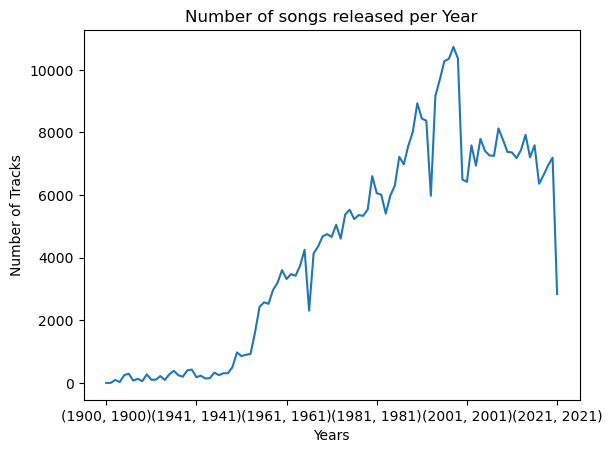

In [45]:
# This code should plot the table above

df2.groupby('release_year')['release_year'].value_counts().plot()
plt.title('Number of songs released per Year')
plt.xlabel('Years')
plt.ylabel('Number of Tracks')

It seems that a good portion of our dataset was released after the 1980s. This makes sence since there was a massive increase in the availability of resources for musicians to record and distribute songs after that time.

-------------

###### Mode

Lets take a look at the proportion of Major to Minor songs in our dataset

In [46]:
# we will do the same process from above with mode

df2['mode'].value_counts() 

1    283194
0    144213
Name: mode, dtype: int64

Text(0, 0.5, 'Number of tracks')

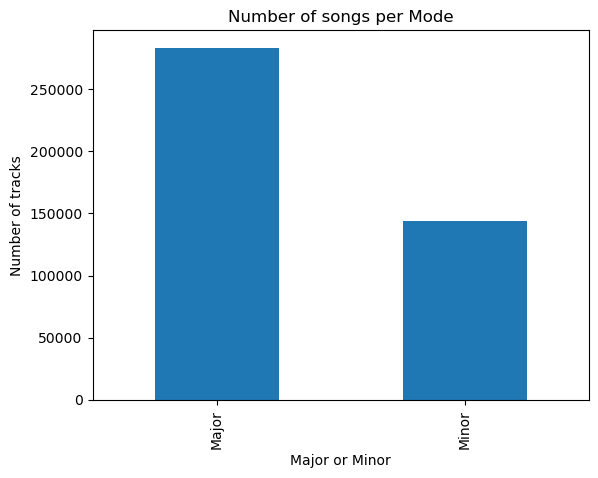

In [47]:
# Plot the result above

df2['mode'].value_counts().plot.bar()
plt.title('Number of songs per Mode')
plt.xticks([0, 1], ['Major', 'Minor'])
plt.xlabel('Major or Minor')
plt.ylabel('Number of tracks')

Let's also see the percentage of modes in our dataset

In [48]:
df2['mode'].value_counts()/df2['mode'].count()*100

1    66.258625
0    33.741375
Name: mode, dtype: float64

It looks like we have mostly Major songs in the dataset, 66% are major and 33% are minor. This means that 66% of the songs in our dataset tend to have a happier and overall uplifting vibe while 33% will tend to have a darker and sadder vibe.

------------------------------

##### Explicit

Lets take a look at how many songs have bad words in the lyrics.

In [49]:
# Here we will count how many songs are explicit

df2['explicit'].value_counts()

0    411282
1     16125
Name: explicit, dtype: int64

Text(0, 0.5, 'Number of tracks')

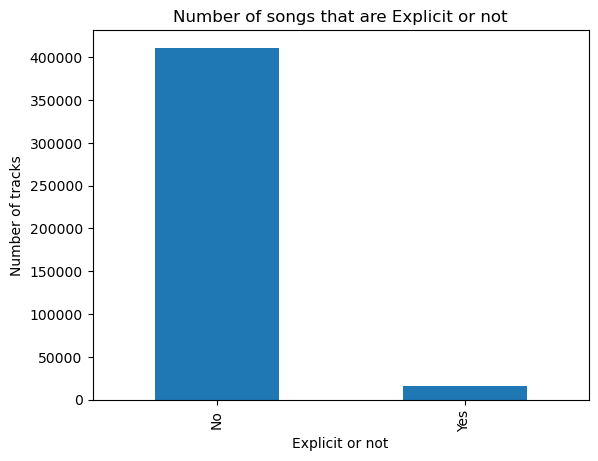

In [50]:
# Here we will plot the frequency of explicit songs in our dataset

df2['explicit'].value_counts().plot.bar()
plt.title('Number of songs that are Explicit or not')
plt.xticks([0, 1], ['No', 'Yes'])
plt.xlabel('Explicit or not')
plt.ylabel('Number of tracks')

Let's also check the percentage of explicit songs in our dataset

In [51]:
df2['explicit'].value_counts()/df2['explicit'].count()*100

0    96.227249
1     3.772751
Name: explicit, dtype: float64

It appears about 96% of the songs in our dataset are not explicit. Therefore the vast majority of songs in our dataset does not contain bad words in the lyrics.

-------------------------

##### Time Signature

Let's see what the proportion of different time signatures is in our dataset.

In [53]:
df2['time_signature'].value_counts()

4    380190
3     39170
5      4981
1      3066
Name: time_signature, dtype: int64

Text(0, 0.5, 'Number of songs')

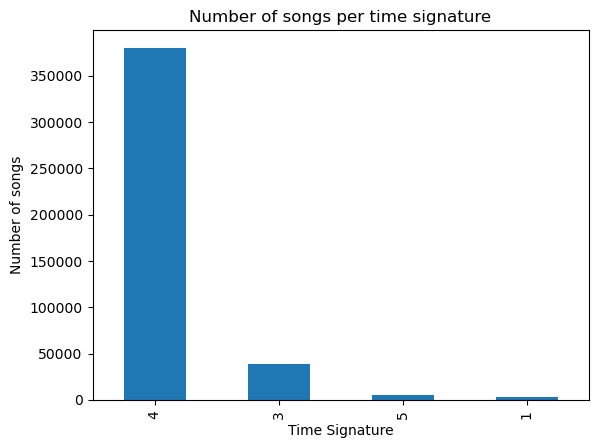

In [52]:
# Here we will see how many songs have a 4/4 signature and how many have an odd time metter

df2['time_signature'].value_counts().plot.bar()
plt.title('Number of songs per time signature')
plt.xlabel('Time Signature')
plt.ylabel('Number of songs')

Let's also check the percentage of time signatures in our dataset

In [55]:
df2['time_signature'].value_counts()/df2['time_signature'].count()*100

4    88.952684
3     9.164567
5     1.165400
1     0.717349
Name: time_signature, dtype: float64

As expected the vast majority of our songs have a 4/4 time signature (about 89%), which tends to be the most common time signature. 3/4 is also somewhat popular (especially in waltz, R&B or ballads). Any other time signature is very rare for our dataset and comprise only less than 2% of our dataset.

----------------------

##### Duration

Let's see what is the overall duration of the songs in our dataset. Let's check our minimum and maximum duration in both minutes and seconds.

In [56]:
print('Min Song Duration in seconds :' + str(df2['duration_sec'].min()))
print('Max Song Duration in seconds :' + str(df2['duration_sec'].max()))

Min Song Duration in seconds :25.893
Max Song Duration in seconds :4995.083


In [57]:
print('Min Song Duration in minutes :' + str(df2['duration_min'].min()))
print('Max Song Duration in minutes :' + str(df2['duration_min'].max()))

Min Song Duration in minutes :0.43155
Max Song Duration in minutes :83.25138333333332


Since we have some songs with over 80 minutes longs we will set an upper limit to our histograms below so we can see the distribution better without visualizing these outliers.

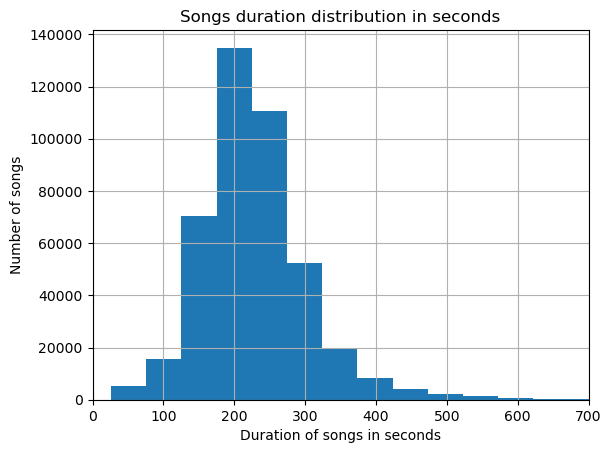

In [58]:
df2['duration_sec'].hist(bins=100)
plt.title('Songs duration distribution in seconds')
plt.xlabel('Duration of songs in seconds')
plt.ylabel('Number of songs')
plt.xlim(0, 700) # This will cut our outliers, we have some songs that will skew the data because they have a long duration
plt.show()

It seems that the vast majority of songs lasts between 120 seconds and 320 seconds. We should see the same results for minutes.

(0.0, 15.0)

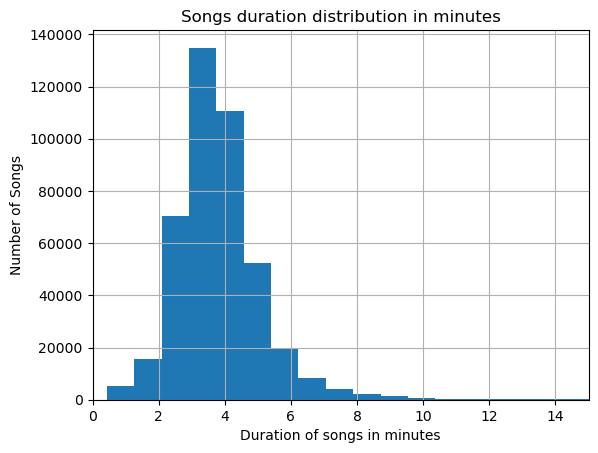

In [59]:
df2['duration_min'].hist(bins=100)
plt.title('Songs duration distribution in minutes')
plt.xlabel('Duration of songs in minutes')
plt.ylabel('Number of Songs')
plt.xlim(0, 15) # again set a limit to cutoff extreme values

As expected, it seems that the vast majority of the songs falls under 2 to 6 minutes of duration, with some extreme outliers lasting all the way up to 83 minutes. Let's take a look at which songs specifically are the longest and shortest ones.

In [60]:
df2_sorted_min = df2.sort_values(by='duration_min', ascending=False)
df2_sorted_min1 = df2.sort_values(by='duration_min', ascending=True)

In [61]:
df2_sorted_min.head(10)

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
233021,Surah Al-Araf,39,0,0.426,0.249,11,-7.202,1,0.0301,0.910000,0.000000,0.1430,0.400,134.168,3,71280.0,Sheikh Mishary Rashid Alfasay,65,2010,4995.083,83.251383
233002,Surah An-Nisa,43,0,0.408,0.258,0,-8.920,1,0.0311,0.916000,0.000000,0.1970,0.437,143.346,3,71280.0,Sheikh Mishary Rashid Alfasay,65,2010,4797.258,79.954300
232990,Surah Aal-E-Imran,44,0,0.402,0.267,2,-6.986,1,0.0312,0.902000,0.000000,0.2790,0.410,142.419,4,71280.0,Sheikh Mishary Rashid Alfasay,65,2010,4725.264,78.754400
230548,Happy New Year Mix 2009,1,0,0.792,0.742,6,-6.899,0,0.0520,0.000599,0.838000,0.0930,0.227,128.001,4,610.0,Dj Emma,2,2009,4696.690,78.278167
67835,L'Etranger,19,0,0.468,0.261,8,-18.226,1,0.5380,0.659000,0.000560,0.0987,0.374,58.624,4,112370.0,Serge Reggiani,49,1983,4585.640,76.427333
270774,Nightbreed 2017 Yearmix - Full Continuous Mix,4,1,0.469,0.975,1,-2.540,1,0.2570,0.098400,0.000031,0.3220,0.119,156.022,4,8596.0,Degos & Re-Done,37,2018,4548.907,75.815117
233018,Al Ruqyah Al Shariah,43,0,0.371,0.472,1,-3.003,1,0.0293,0.858000,0.000000,0.2680,0.322,140.716,4,71280.0,Sheikh Mishary Rashid Alfasay,65,2012,4397.767,73.296117
233017,Surah Al-Anaam,39,0,0.417,0.308,11,-5.866,1,0.0289,0.902000,0.000000,0.3400,0.346,136.527,3,71280.0,Sheikh Mishary Rashid Alfasay,65,2010,4350.067,72.501117
233728,The Year 2011 ReBeat,6,0,0.660,0.876,11,-6.553,0,0.0563,0.007240,0.001960,0.0432,0.522,128.688,4,185.0,DJ JT,4,2011,4317.063,71.951050
290050,Nightbreed 2019 Yearmix - Full Continuous Mix,3,1,0.433,0.969,1,-2.428,1,0.2020,0.022900,0.000000,0.4670,0.177,156.025,4,9757.0,Bass Chaserz,44,2019,4258.406,70.973433


In [62]:
df2_sorted_min1.head(10)

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
10235,The Lollipop Guild - Original Munchkin Actors'...,1,0,0.571,0.2540,5,-16.863,1,0.1930,0.787000,0.102000,0.218,0.9270,178.530,4,620.0,The Munchkins,31,1939,25.893,0.431550
235770,Pegasus (Mix Cut) - Original Mix,4,0,0.404,0.9610,10,-7.525,0,0.0425,0.000088,0.915000,0.380,0.6110,127.989,4,32139.0,Protoculture,45,2015,30.016,0.500267
44961,Heroes And Villains: Children Were Raised - Ma...,47,0,0.624,0.2150,6,-17.019,1,0.0577,0.810000,0.000000,0.137,0.2290,111.240,4,3084545.0,The Beach Boys,76,2011,30.027,0.500450
37582,Dave Brubeck (with Steve Allen),19,0,0.754,0.3030,0,-14.455,1,0.1520,0.957000,0.000607,0.266,0.6600,118.150,4,15042.0,Jack Kerouac,32,1959,30.040,0.500667
175758,"Fireworks - From ""The Little Mermaid""/Score",16,0,0.234,0.0700,7,-22.983,1,0.0452,0.510000,0.244000,0.185,0.0461,117.602,4,86093.0,Alan Menken,64,1989,30.053,0.500883
274057,Animaux / Chevaux: passage sur le pavè,16,0,0.753,0.6520,5,-27.928,0,0.2380,0.038500,0.907000,0.210,0.0653,112.519,4,425.0,Bruitages,28,1974,30.067,0.501117
25355,Y Cyntaf Dydd O'r Gwyliau,2,0,0.569,0.0343,4,-18.613,1,0.2250,0.981000,0.000000,0.259,0.5680,114.369,5,268.0,Meredydd Evans,12,1954,30.093,0.501550
406417,Santi Niggi Näggi,11,0,0.782,0.2110,0,-11.849,1,0.2530,0.981000,0.000000,0.112,0.4970,58.629,4,35295.0,Traditional,65,1981,30.107,0.501783
237848,Shadow [Mix Cut] - W&W Edit,3,0,0.423,0.9470,4,-5.630,0,0.0333,0.000024,0.776000,0.810,0.4980,130.030,4,33087.0,Mark Sixma,56,2014,30.146,0.502433
354499,Banjo-Vagn Vol.2,13,0,0.828,0.3560,2,-13.053,1,0.3570,0.919000,0.000000,0.368,0.9710,123.471,4,8458.0,De Nattergale,34,1992,30.173,0.502883


Here we can see that the songs with the longest duration are some DJ sets, which makes sense since these tend to be very long. 

There is no clear pattern between the shorter songs, some of them are some cut versions of longer songs.

----------------------------

##### Valence

Let's take s look at the valence of our dataset.

Average Valence: 0.5637236040588953


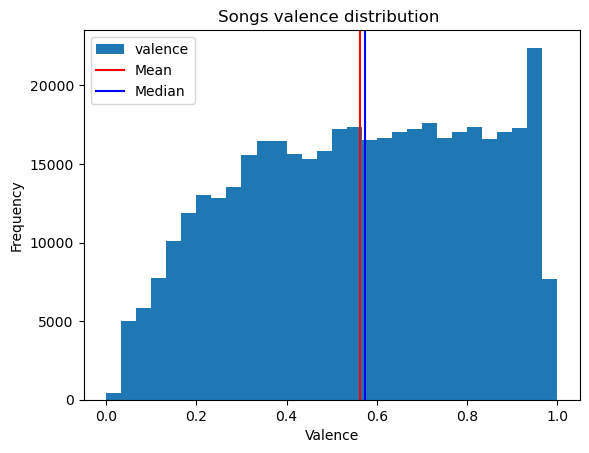

In [63]:
# This code should plot a histogram to see how Valence is distributed through our dataset


df2['valence'].plot.hist(bins=30)
plt.title('Songs valence distribution ')
plt.axvline(x=df2['valence'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['valence'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Valence')

print('Average Valence: ' + str(df2['valence'].mean()))

It appears most of our songs have high valence, which means most of the songs in the dataset are upbeat and represent emotions like happiness. making this variable a little bit left-skewed. This is correlated with the results we saw while plotting the "mode" variable, Major songs will tend to have high valence and minor songs will tend to have low valence (though not necessarily).

------------------------

##### Danceability

Let's take a look at the danceability of our dataset songs

Average Danceability: 0.5634091201126874


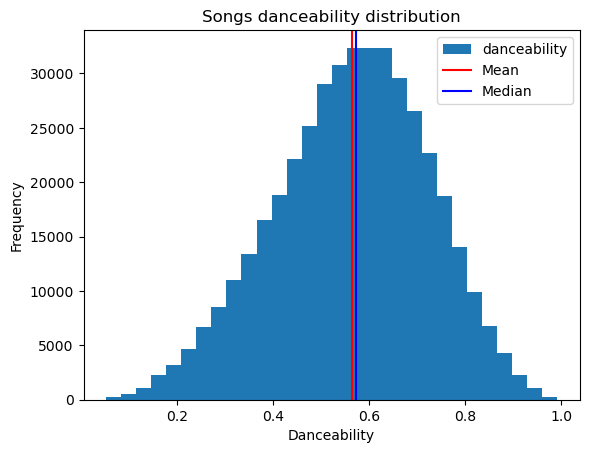

In [64]:
# here we will see the distribution of danceability throughout the dataset

df2['danceability'].plot.hist(bins=30)
plt.title('Songs danceability distribution')
plt.axvline(x=df2['danceability'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['danceability'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Danceability')

print('Average Danceability: ' + str(df2['danceability'].mean()))

It seems like most of our songs are somewhere close to our average danceability, which indicates a normal distribution. 

This means we have a lot of songs that are appropriate for dancing.

----------------------------------

##### Energy

Let's take a look at the overall energy of our dataset

Average Energy: 0.5711838964020277


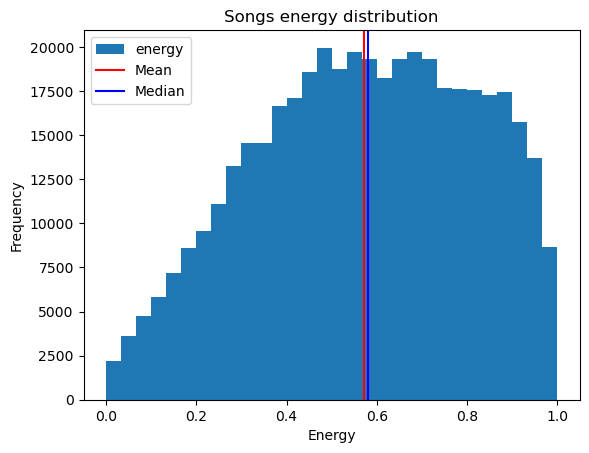

In [65]:
# here we will see the distribution of energy throughout the dataset

df2['energy'].plot.hist(bins=30)
plt.title('Songs energy distribution')
plt.axvline(x=df2['energy'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['energy'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Energy')

print('Average Energy: ' + str(df2['energy'].mean()))

It appears that our dataset tends to have higher energy, making it slightly left skewed.

---------------------------------

##### Loudness

Let's take a look at the loudness of our dataset now

Average : Loudness-9.546410330200763


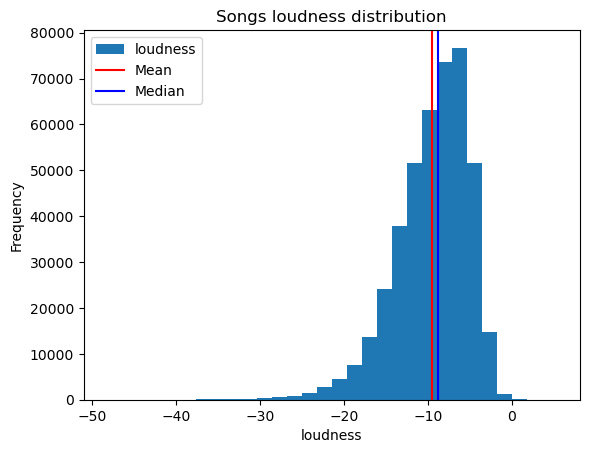

In [66]:
df2['loudness'].plot.hist(bins=30)
plt.title('Songs loudness distribution')
plt.axvline(x=df2['loudness'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['loudness'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('loudness')

print('Average : Loudness' + str(df2['loudness'].mean()))

The loudness of our dataset looks somewhat normal with a slight left skew. Most of our songs appear to have an overall volume between -15dbs and -5dbs.

----------------------------------

##### Key

Now let's look at the keys we see more often in our dataset.

In [68]:
df2['key'].value_counts()

0     56011
7     55051
9     51043
2     50367
5     38186
4     37444
11    28650
1     26779
10    25913
8     22408
6     21245
3     14310
Name: key, dtype: int64

Text(0, 0.5, 'Number of Songs')

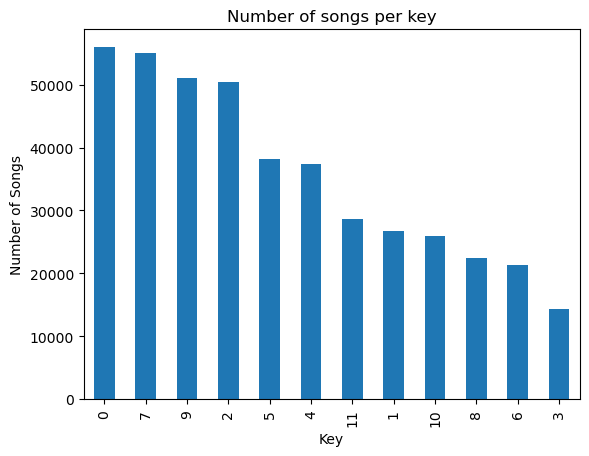

In [69]:
df2['key'].value_counts().plot.bar()
plt.title('Number of songs per key')
plt.xlabel('Key')
plt.ylabel('Number of Songs')

Let's also take a look at the percentage of the keys being used in the dataset

In [70]:
df2['key'].value_counts()/df2['key'].count()*100

0     13.104839
7     12.880229
9     11.942481
2     11.784318
5      8.934341
4      8.760736
11     6.703213
1      6.265457
10     6.062839
8      5.242778
6      4.970672
3      3.348097
Name: key, dtype: float64

The key of 0 represents a song in C which is the most common key, followed by the key of F# (7), G# (9), and D (2). Which appear to be the four most common keys in our dataset. These 4 keys should account for about 50% of the keys found in the dataset.

-----------------------------------

##### Speechiness

Speechiness is how much of the song is comprised of speech, we have previously set an upper limit of 0.66 while cleaning the data to filter out talk shows and podcasts.

Average Speechiness: 0.0675548149655957


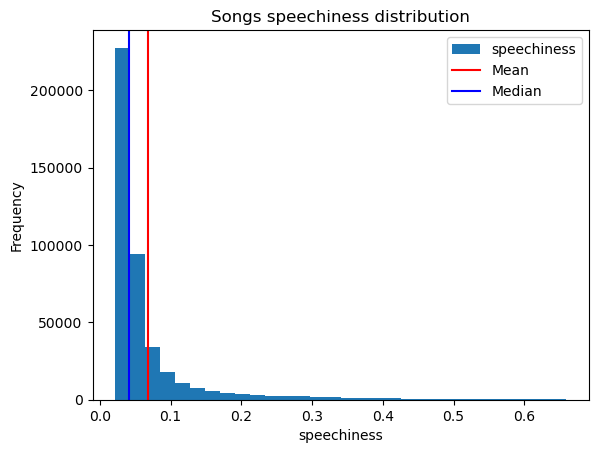

In [71]:
df2['speechiness'].plot.hist(bins=30)
plt.title('Songs speechiness distribution')
plt.axvline(x=df2['speechiness'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['speechiness'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('speechiness')

print('Average Speechiness: ' + str(df2['speechiness'].mean()))

We can see that the vast majority of our songs have very little speechiness, representing actual songs. The songs with higher speechiness might be raps or other genres with a lot of spoken vocals. This is what we expect in order to analyze our songs, we want most of our songs to fall between 0.0 and 0.1 speechiness.

-------------------------------------

##### Acousticness

Let's see the overall acousticness of our dataset.

Average Acousticness: 0.4003432330289581


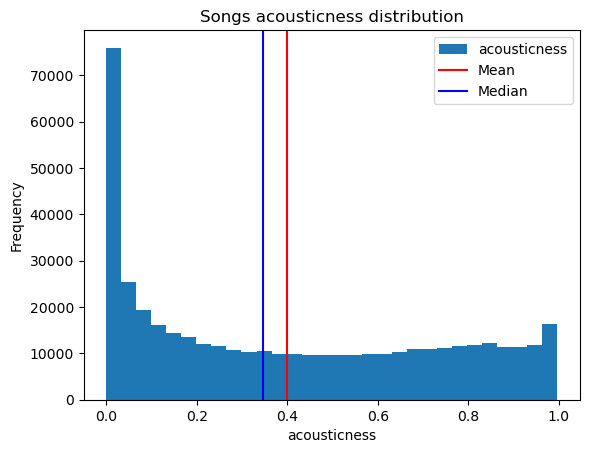

In [72]:
df2['acousticness'].plot.hist(bins=30)
plt.title('Songs acousticness distribution')
plt.axvline(x=df2['acousticness'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['acousticness'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('acousticness')

print('Average Acousticness: ' + str(df2['acousticness'].mean()))

This plot represents that a good portion of our songs in our dataset are not detected as acoustic. However most songs will not fall under the acoustic or not acoustic classification (exactly 0 or 1), they will probably fall somewhere between 0 and 1.

-------------------------------

##### Instrumentalness

Let's take a look at the overall instrumentalness of our dataset.

Average Instrumentalness: 0.08334417231420573


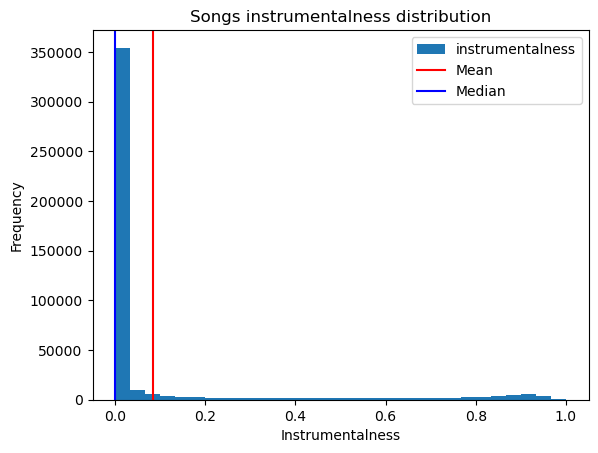

In [73]:
df2['instrumentalness'].plot.hist(bins=30)
plt.title('Songs instrumentalness distribution')
plt.axvline(x=df2['instrumentalness'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['instrumentalness'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Instrumentalness')

print('Average Instrumentalness: ' + str(df2['instrumentalness'].mean()))

This means most of our songs in our dataset contain vocals, very few songs are composed of only instruments.

The instrumental-only songs should lie between 0.8 and 1.0 in our instrumentalness column

---------------------------------

##### Liveness

Now how much of our dataset was recorded live

Average Liveness: 0.205998869508452


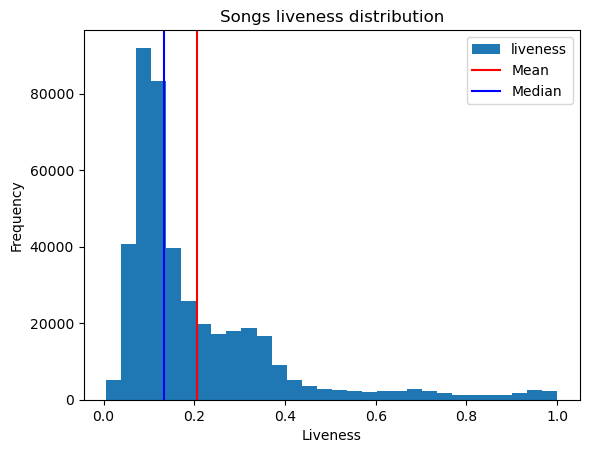

In [74]:
df2['liveness'].plot.hist(bins=30)
plt.title('Songs liveness distribution')
plt.axvline(x=df2['liveness'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['liveness'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Liveness')

print('Average Liveness: ' + str(df2['liveness'].mean()))

Most of our songs appear to not be live recordings. This variable detects live audiences and live performances, but the vast majority of our songs falls between 0 and 0.4, which is a strong confidence interval for songs recorded in studio.

Songs falling between 0.8 and 1.0 are probably recorded live. This feature detects live audiences and other characteristics of live music.

---------------------------

##### Popularity

Now we will take a look at our target variable, the song popularity

Average Popularity: 30.23875603347629


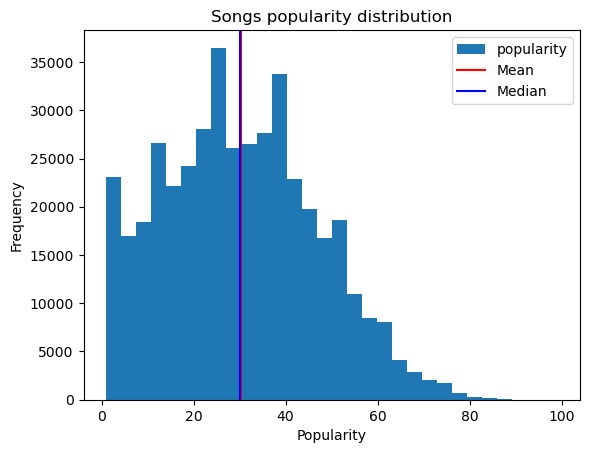

In [75]:
df2['popularity'].plot.hist(bins=30)
plt.title('Songs popularity distribution')
plt.axvline(x=df2['popularity'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['popularity'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Popularity')

print('Average Popularity: ' + str(df2['popularity'].mean()))

Our target variable appears to be somewhat normally distributed with a slight right skew. Our average popularity seems to be at 30 even though the values range from 1 to 100. 

We have some outliers between 90 and 100 which represent very popular songs.

Let's take a look at some of the most popular and the most unpopular songs in our dataset.

In [76]:
df2_sorted_pop = df2.sort_values(by='popularity', ascending=False)
df2_sorted_pop1 = df2.sort_values(by='popularity', ascending=True)

In [77]:
df2_sorted_pop.head(10)

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
245739,drivers license,99,1,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,4,1444702.0,Olivia Rodrigo,88,2021,242.014,4.033567
247131,Astronaut In The Ocean,98,0,0.778,0.695,4,-6.865,0,0.0913,0.17500,0.000000,0.1500,0.472,149.996,4,177401.0,Masked Wolf,85,2021,132.780,2.213000
241165,telepatía,97,0,0.653,0.524,11,-9.016,0,0.0502,0.11200,0.000000,0.2030,0.553,83.970,4,1698014.0,Kali Uchis,88,2020,160.191,2.669850
235154,Save Your Tears,97,1,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,4,31308207.0,The Weeknd,96,2020,215.627,3.593783
235155,Blinding Lights,96,0,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4,31308207.0,The Weeknd,96,2020,200.040,3.334000
215569,The Business,95,0,0.798,0.620,8,-7.079,0,0.2320,0.41400,0.019200,0.1120,0.235,120.031,4,5527032.0,Tiësto,87,2020,164.000,2.733333
240085,Streets,94,1,0.749,0.463,11,-8.433,1,0.0828,0.20800,0.037100,0.3370,0.190,90.028,4,6208117.0,Doja Cat,91,2019,226.987,3.783117
246368,Heartbreak Anniversary,94,0,0.449,0.465,0,-8.964,1,0.0791,0.52400,0.000001,0.3030,0.543,89.087,3,946550.0,Giveon,91,2020,198.371,3.306183
246278,WITHOUT YOU,94,1,0.662,0.413,0,-7.357,1,0.0299,0.21300,0.000000,0.1340,0.467,93.005,4,1624015.0,The Kid LAROI,90,2020,161.385,2.689750
243683,Good Days,93,1,0.436,0.655,1,-8.370,0,0.0583,0.49900,0.000008,0.6880,0.412,121.002,4,5082658.0,SZA,88,2020,279.204,4.653400


In [78]:
df2_sorted_pop1.head()

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
297657,Looking for Real Love,1,0,0.798,0.71900,11,-8.898,0,0.0514,0.0585,0.00102,0.0923,0.546,131.428,4,61008.0,Hollie Cook,49,2014,361.796,6.029933
19854,Let Me Call You Sweetheart,1,0,0.288,0.00388,0,-11.793,1,0.0560,0.3930,0.94400,0.0884,0.533,103.412,3,1668.0,Ken Griffin,21,1951,161.533,2.692217
313184,Broche de Oro,1,0,0.326,0.57100,3,-7.131,1,0.0343,0.8100,0.74600,0.4450,0.946,171.846,4,755.0,Banda Bajera De San Pelayo,6,1963,182.349,3.039150
313183,El Relámpago,1,0,0.356,0.86000,5,-7.801,1,0.0593,0.7060,0.54300,0.5740,0.376,67.924,4,755.0,Banda Bajera De San Pelayo,6,1963,170.752,2.845867
313182,Soy Pelayero (Instrumental),1,0,0.292,0.83600,3,-7.829,1,0.0595,0.8610,0.54700,0.1210,0.846,167.632,4,755.0,Banda Bajera De San Pelayo,6,1963,170.032,2.833867


We can see that our most popular songs are very well known and were composed by famous artists (these are our outliers). However, the vast majority of our songs will fall under 0 to 80 in the popularity score.

-------------------------------------------------

##### Followers

Let's take a look at the number of followers on spotify per artist. 

However, since every entry of our dataset represents one song we should create a new dataset with every unique artist only appearing once, to see better the distribution of followers per artist and not per song.

In [79]:
# number of unique artists

df2['artist'].nunique()

51426

In [80]:
# Create a new df with just the unique artists

df2_uniq_art = df2.drop_duplicates(subset=["artist"])

In [82]:
# Sanity check
df2_uniq_art.head()

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
0,Carve,6,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,Uli,4,1922,126.903,2.115050
1,Tu Verras Montmartre,1,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,Lucien Boyer,4,1922,186.800,3.113333
2,Nuits De Chine,4,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,Louis Lynel,2,1922,180.800,3.013333
4,Nobody Knows You When You're Down and Out,41,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,Bessie Smith,44,1923,177.133,2.952217
48,Ain't Misbehavin',28,0,0.665,0.2540,8,-9.879,1,0.1080,0.976,0.002170,0.644,0.503,125.734,4,2256652.0,Louis Armstrong,74,1923,192.600,3.210000


In [83]:
# Sanity check, see if this DF matches the unique values in the original dataset

df2_uniq_art.shape

(51426, 21)

Average Followers: 1133194.6707119911


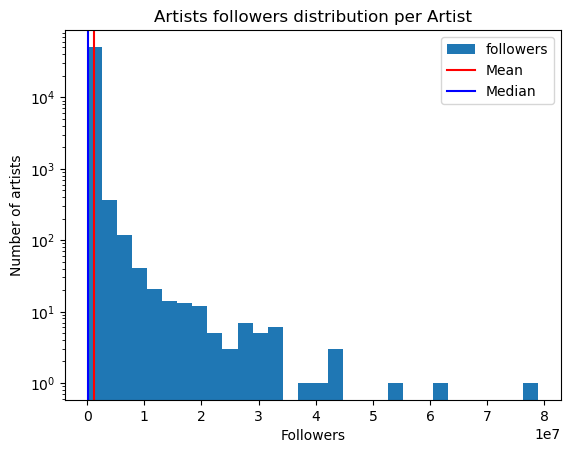

In [84]:
# Plot the distribution of followers per artist

df2_uniq_art['followers'].plot.hist(bins=30, log=True) # Log=True makes it a log scale
plt.title('Artists followers distribution per Artist')
plt.axvline(x=df2['followers'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['followers'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Followers')
plt.ylabel('Number of artists')

print('Average Followers: ' + str(df2['followers'].mean()))

Followers data is highly skewed. 

It makes sense to use a log scale in the plot since there is no upper limit to followers. We can have artists with 1 follower or over 70 million. Let's investiagete exactly how many followers our extreme values have.

In [85]:
print('Min Followers :' + str(df2_uniq_art['followers'].min()))
print('Max Followers :' + str(df2_uniq_art['followers'].max()))

Min Followers :1.0
Max Followers :78900234.0


We can also take a look at the specific artists with the most and least followers

In [86]:
df2_uniq_sorted = df2_uniq_art.sort_values(by='followers', ascending=False)
df2_uniq_sorted1 = df2_uniq_art.sort_values(by='followers', ascending=True)

In [87]:
df2_uniq_sorted.head(10)

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
233205,The A Team,77,0,0.642,0.289,9,-9.918,1,0.0367,0.669000,0.000000,0.1800,0.407,84.996,4,78900234.0,Ed Sheeran,92,2011,258.373,4.306217
238570,Baby I,62,0,0.724,0.796,1,-3.686,1,0.0328,0.015200,0.000000,0.3540,0.542,101.975,4,61301006.0,Ariana Grande,95,2013,197.600,3.293333
229425,Best I Ever Had,76,1,0.395,0.922,1,-2.176,1,0.3750,0.190000,0.000000,0.1340,0.558,162.361,4,54416812.0,Drake,98,2009,257.690,4.294833
229730,One Time,71,0,0.691,0.853,1,-2.528,0,0.0372,0.063100,0.000071,0.0820,0.762,145.999,4,44606973.0,Justin Bieber,100,2009,215.867,3.597783
196107,Infinite,57,1,0.637,0.862,10,-4.343,0,0.1910,0.293000,0.000000,0.2170,0.573,82.019,4,43747833.0,Eminem,94,1996,251.707,4.195117
221726,Pon de Replay,80,0,0.779,0.640,7,-8.415,1,0.1590,0.000155,0.000770,0.1010,0.498,99.019,4,42244011.0,Rihanna,92,2005,246.960,4.116000
241965,Six Feet Under,77,0,0.576,0.307,11,-12.732,0,0.0428,0.807000,0.000355,0.0792,0.157,67.513,4,41792604.0,Billie Eilish,92,2016,189.613,3.160217
224916,Our Song,62,0,0.667,0.659,2,-4.932,1,0.0298,0.113000,0.000000,0.3250,0.575,89.128,4,38869193.0,Taylor Swift,98,2006,203.440,3.390667
234847,Demons,82,0,0.505,0.710,3,-3.015,1,0.0321,0.190000,0.000250,0.2690,0.428,89.938,4,33665795.0,Imagine Dragons,89,2012,177.507,2.958450
91705,Liar - Remastered 2011,54,0,0.217,0.784,2,-7.202,1,0.1530,0.002520,0.077500,0.1950,0.270,79.181,4,33483326.0,Queen,89,1973,383.907,6.398450


In [88]:
df2_uniq_sorted1.head(10)

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
307692,Ellos Dicen,38,1,0.682,0.8420,5,-4.879,0,0.2300,0.19400,0.000000,0.0845,0.535,82.695,4,1.0,Lombert,23,2016,199.550,3.325833
428022,Shine On Me,11,0,0.583,0.4840,10,-7.269,1,0.0326,0.53100,0.000000,0.1160,0.335,121.905,4,1.0,Jai,3,2015,236.680,3.944667
409949,Good Bye Blues (Live),11,0,0.598,0.4630,2,-9.437,1,0.0423,0.47500,0.021700,0.2640,0.563,80.004,4,1.0,Oscar Klein Quartett,19,1998,77.107,1.285117
358314,Örnin flýgur fugla hæst - Sólskríkjan mín,2,0,0.216,0.2170,5,-13.636,1,0.0370,0.59900,0.000000,0.1170,0.317,134.132,4,1.0,Berglind Bjarnadóttir,3,1977,67.477,1.124617
427912,車頂美姑娘,1,0,0.461,0.7300,9,-10.803,0,0.0563,0.70300,0.716000,0.7850,0.497,140.186,4,1.0,銀河大樂隊,6,1975,156.679,2.611317
411533,Nem adlak kölcsön,24,0,0.772,0.8880,1,-9.446,1,0.0379,0.00751,0.049500,0.3390,0.970,137.966,4,1.0,Bubble Gum,11,2014,207.987,3.466450
354051,Sømandssang,3,0,0.829,0.2470,10,-14.200,1,0.0631,0.91800,0.000008,0.1250,0.956,116.965,1,1.0,"Daimi, Katrine Jensenius, Christiane Rohde",1,1962,152.026,2.533767
354048,Pippi begynder i skole,4,0,0.701,0.0448,0,-21.946,0,0.6270,0.63200,0.000000,0.1460,0.359,133.511,5,1.0,Tina Wilhelmsen,3,1962,473.205,7.886750
412130,Prema Kosamai,7,0,0.526,0.3370,7,-13.841,1,0.0681,0.99500,0.887000,0.1170,0.734,73.444,4,1.0,V.J.Varma,1,1951,168.720,2.812000
412232,Pambarakkannaale,4,0,0.488,0.5640,1,-14.301,1,0.0494,0.65300,0.020100,0.3620,0.869,66.962,4,1.0,S.Shanmuga Sundaram,2,1957,205.733,3.428883


It appears that the artist with the most followers is Ed Sheeran, followed by some other giants in the music industry like Ariana Grande, Drake, Justin Bieber, Eminem and so on. 

Plus, it appears we have plenty of unkown artists with only one follower, these don't seem to follow any specific pattern so far.

----------------------------

##### Artist Popularity

Now let's take a look at artist popularity.

Again, looking at the distribution of this variable per artist and not per song, so we will keep working with the dataset we created while plotting the previous feature (We used df2_uniq_art_ for Followers).

Average Artists Popularity: 51.611035851074035


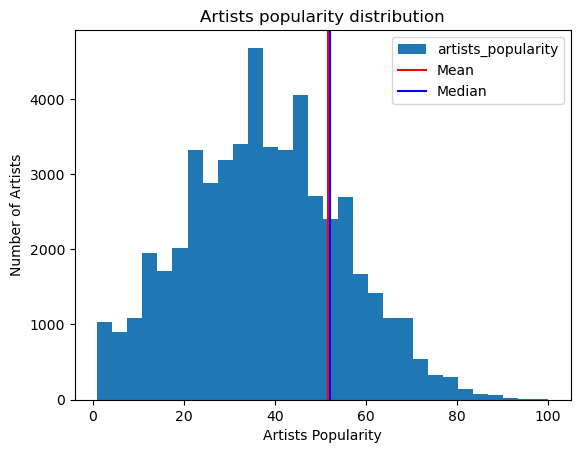

In [89]:
df2_uniq_art['artists_popularity'].plot.hist(bins=30)
plt.title('Artists popularity distribution')
plt.axvline(x=df2['artists_popularity'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['artists_popularity'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Artists Popularity')
plt.ylabel('Number of Artists')

print('Average Artists Popularity: ' + str(df2['artists_popularity'].mean()))

We have an almost normal distribution with a right tail, skewing slightly the data to the right. Our values range from 1 to 100, but we can investigate further to see who are the artists we have in each end of the distribution.

In [90]:
# Create df sorted

df2_sorted_art = df2_uniq_art.sort_values(by='artists_popularity', ascending=False)
df2_sorted_art1 = df2_uniq_art.sort_values(by='artists_popularity', ascending=True)

In [91]:
df2_sorted_art.head(10)

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
229730,One Time,71,0,0.691,0.853,1,-2.528,0,0.0372,0.06310,0.000071,0.082,0.762,145.999,4,44606973.0,Justin Bieber,100,2009,215.867,3.597783
224916,Our Song,62,0,0.667,0.659,2,-4.932,1,0.0298,0.11300,0.000000,0.325,0.575,89.128,4,38869193.0,Taylor Swift,98,2006,203.440,3.390667
242136,Soy Peor,74,1,0.808,0.611,0,-3.221,0,0.0663,0.68300,0.006380,0.114,0.172,116.011,4,32244734.0,Bad Bunny,98,2016,257.384,4.289733
229425,Best I Ever Had,76,1,0.395,0.922,1,-2.176,1,0.3750,0.19000,0.000000,0.134,0.558,162.361,4,54416812.0,Drake,98,2009,257.690,4.294833
237257,No More Dream,69,0,0.436,0.869,2,-5.174,1,0.4720,0.01240,0.000002,0.494,0.612,167.766,4,31623813.0,BTS,96,2013,221.593,3.693217
244486,Lucid Dreams,88,1,0.511,0.566,6,-7.230,0,0.2000,0.34900,0.000000,0.340,0.218,83.903,4,16996777.0,Juice WRLD,96,2018,239.836,3.997267
235124,Wicked Games,75,1,0.658,0.591,9,-5.197,1,0.0309,0.00959,0.000005,0.325,0.326,114.078,4,31308207.0,The Weeknd,96,2012,323.747,5.395783
238570,Baby I,62,0,0.724,0.796,1,-3.686,1,0.0328,0.01520,0.000000,0.354,0.542,101.975,4,61301006.0,Ariana Grande,95,2013,197.600,3.293333
241000,Be the One,73,0,0.661,0.651,7,-3.771,0,0.0499,0.11700,0.000013,0.056,0.368,87.460,4,24123468.0,Dua Lipa,95,2015,202.915,3.381917
239193,Ay Vamos,70,0,0.718,0.711,8,-5.746,0,0.1100,0.15700,0.000055,0.100,0.920,173.916,4,27286822.0,J Balvin,95,2014,226.413,3.773550


In [92]:
df2_sorted_art1.head(10)

,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist,artists_popularity,release_year,duration_sec,duration_min
386061,I Cadetti Di Guascogna,3,0,0.758,0.3040,7,-20.691,1,0.4050,0.957,0.320000,0.1170,0.933,119.186,4,6.0,Clara Jaione con Orchestra Armando Fragna,1,1946,161.427,2.690450
427911,Somebody Else,3,0,0.371,0.0922,1,-16.613,1,0.0479,0.956,0.004140,0.2910,0.103,173.358,4,13.0,Adib,1,1975,96.756,1.612600
4462,Have Yourself A Merry Little Christmas,3,0,0.212,0.1760,8,-14.327,1,0.0300,0.865,0.000019,0.1220,0.158,150.348,3,39.0,Tex Beneke And His Orchestra,1,1932,167.827,2.797117
247537,The Day You Came Along,1,0,0.366,0.1420,3,-16.500,1,0.0353,0.985,0.966000,0.1660,0.110,67.525,4,32.0,Jimmy Rowles Trio,1,1954,228.280,3.804667
19143,Till There Was You,7,0,0.741,0.3380,8,-11.778,1,0.0377,0.869,0.002750,0.1170,0.834,123.913,4,14.0,Sandra Hillawi,1,1950,131.918,2.198633
415861,Spring is Here,6,0,0.428,0.1160,11,-28.497,0,0.0768,0.960,0.044100,0.2890,0.726,112.370,5,27.0,Parwin,1,1961,356.880,5.948000
4497,"Bewitched, Bothered and Bewildered - From "" Pa...",1,0,0.366,0.0972,0,-14.313,1,0.0523,0.973,0.000000,0.1340,0.418,79.546,4,24.0,Vivienne Segal,1,1932,188.800,3.146667
290631,Tanssin sun kanssasi aamuun,2,0,0.562,0.3410,1,-7.583,1,0.0335,0.756,0.000061,0.3190,0.544,119.124,4,114.0,Oili Vainio,1,1961,213.333,3.555550
4500,Les gars de la marine,2,0,0.724,0.4790,7,-8.579,1,0.0946,0.953,0.000007,0.0716,0.828,126.937,4,26.0,Jean Cyrano,1,1932,169.787,2.829783
403685,Kanji Tari Maa Keshe,2,0,0.616,0.2570,7,-12.325,0,0.0336,0.986,0.006800,0.2260,0.354,102.712,3,11.0,Abhram Bhagat,1,1950,185.467,3.091117


Curiously, we did not get Ed Sheeran as the most popular artist even though he is the artist with the most followers on Spotify.

Instead, we got Justin Bieber as the most popular artist. This means that while Ed Sheeran has more followers on Spotify, Justin Bieber was ranked higher on artist popularity. Other very popular artists include Taylor Swift, Bad Bunny, Drake, BTS, Juice WRLD and so on.

We once again had a lot of random artist scoring only 1 in artist popularity. Curiously though, these artists have varying numbers of followers. Which means that followers does not necessarily translate to artist popularity.

-----------------------------------

### Feature engineering<a class="anchor" id="6-bullet"></a>

##### Feature Engineering number of songs per artist (NOS_artist)

Here we can create one new feature that can potentially improve our models further.

We should create a column with the counts of songs each artist has. This could be insightful for us to understand whether popular artists tend to have more or fewer songs. Thus, this can also show us hidden patterns popular songs could have. For example, do popular songs tend to be one hit wonders or do they tend to be composed by dedicated artists that release a lot of songs?

In [93]:
# Set a dataframe with the song counts per artist

counts_songs = df2['artist'].value_counts()

In [94]:
# Merge both datasets on artist

df2 = pd.merge(df2, counts_songs, left_on='artist', right_index=True)

In [95]:
df2.head(20)

,artist,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artist_x,artists_popularity,release_year,duration_sec,duration_min,artist_y
0,Uli,Carve,6,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.127,104.851,3,91.0,Uli,4,1922,126.903,2.115050,1
1,Lucien Boyer,Tu Verras Montmartre,1,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.1630,0.897,127.531,4,80.0,Lucien Boyer,4,1922,186.800,3.113333,1
2,Louis Lynel,Nuits De Chine,4,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.1960,0.400,139.575,3,39.0,Louis Lynel,2,1922,180.800,3.013333,2
3,Louis Lynel,Les ménétriers,2,0,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.1350,0.647,79.817,4,39.0,Louis Lynel,2,1924,149.760,2.496000,2
4,Bessie Smith,Nobody Knows You When You're Down and Out,41,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.1830,0.211,89.822,4,116265.0,Bessie Smith,44,1923,177.133,2.952217,44
5,Bessie Smith,'Tain't Nobody's Bizness If I Do,30,0,0.537,0.0443,3,-16.474,0,0.0343,0.996,0.000265,0.1520,0.137,80.468,4,116265.0,Bessie Smith,44,1923,206.600,3.443333,44
6,Bessie Smith,"Empty Bed Blues, Pt. 1",27,0,0.709,0.0620,5,-12.207,1,0.0480,0.995,0.003410,0.1200,0.553,85.854,4,116265.0,Bessie Smith,44,1923,181.173,3.019550,44
7,Bessie Smith,Need a Little Sugar in My Bowl,27,0,0.693,0.0270,0,-13.506,0,0.0562,0.992,0.000000,0.1340,0.402,75.749,4,116265.0,Bessie Smith,44,1923,167.640,2.794000,44
8,Bessie Smith,Send Me to the 'Lectric Chair,26,0,0.771,0.0905,3,-7.788,1,0.0613,0.986,0.000141,0.1520,0.601,87.571,4,116265.0,Bessie Smith,44,1923,201.480,3.358000,44
9,Bessie Smith,Young Woman's Blues,25,0,0.525,0.2320,8,-7.649,1,0.0335,0.995,0.018100,0.4610,0.411,76.140,4,116265.0,Bessie Smith,44,1923,187.960,3.132667,44


It appears our merge worked, we should now rename our columns so that they are not confusing. Our join added the name of the artist a second time (artist_x) and added the column we want, the count of songs per artist, with another name (artist_y).

In [96]:
# drop duplicated column

df2 = df2.drop(columns='artist_x')

# rename count column

df2 = df2.rename(columns={'artist_y': 'NOS_artist'})

In [97]:
# sanity check
df2.head()

,artist,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artists_popularity,release_year,duration_sec,duration_min,NOS_artist
0,Uli,Carve,6,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,4,1922,126.903,2.115050,1
1,Lucien Boyer,Tu Verras Montmartre,1,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,4,1922,186.800,3.113333,1
2,Louis Lynel,Nuits De Chine,4,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,2,1922,180.800,3.013333,2
3,Louis Lynel,Les ménétriers,2,0,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.135,0.647,79.817,4,39.0,2,1924,149.760,2.496000,2
4,Bessie Smith,Nobody Knows You When You're Down and Out,41,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,44,1923,177.133,2.952217,44


It seems we have sucessfully created our new variable which contains the counts of songs each artist has composed. Now we can plot and take a deeper look into our new variable.

Average Number of songs recorded by artist: 74.33504130723175


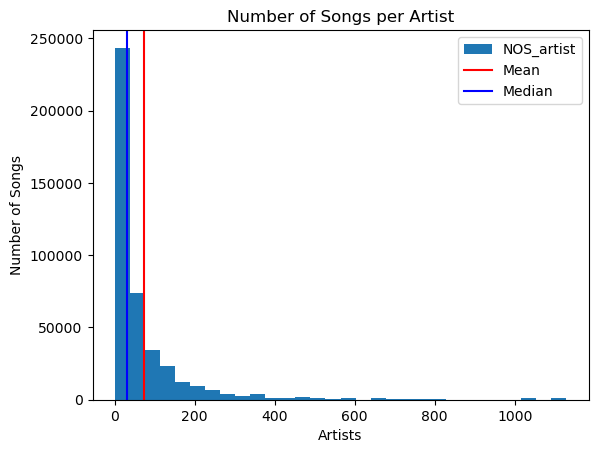

In [98]:
df2['NOS_artist'].plot.hist(bins=30)
plt.title('Number of Songs per Artist')
plt.axvline(x=df2['NOS_artist'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['NOS_artist'].median(), color='b', linestyle='-', label='Median')
plt.legend()
plt.xlabel('Artists')
plt.ylabel('Number of Songs')

print('Average Number of songs recorded by artist: ' + str(df2['NOS_artist'].mean()))

Since we have some extreme values we can set an upper limit to take a closer look at the distribution of our new variable.

Average Number of songs recorded by artist:74.33504130723175


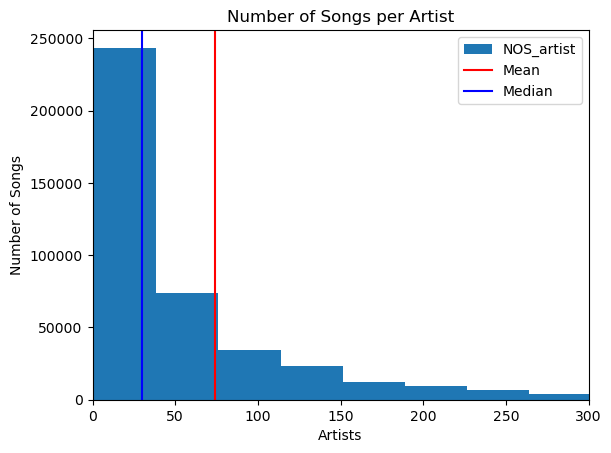

In [99]:
df2['NOS_artist'].plot.hist(bins=30)
plt.title('Number of Songs per Artist')
plt.axvline(x=df2['NOS_artist'].mean(), color='r', linestyle='-', label='Mean')
plt.axvline(x=df2['NOS_artist'].median(), color='b', linestyle='-', label='Median')
plt.xlim(0, 300)
plt.legend()
plt.xlabel('Artists')
plt.ylabel('Number of Songs')

print('Average Number of songs recorded by artist:' + str(df2['NOS_artist'].mean()))

Now let's take a look at the artists with the most and least songs.

In [100]:
df2_nos = df2.sort_values(by='NOS_artist', ascending=False)
df2_nos1 = df2.sort_values(by='NOS_artist', ascending=True)

In [101]:
df2_nos.head()

,artist,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artists_popularity,release_year,duration_sec,duration_min,NOS_artist
8973,Lata Mangeshkar,Aap Yun Faaslon Se,13,0,0.451,0.441,3,-8.107,1,0.0358,0.895,0.000006,0.1230,0.338,77.010,4,2612197.0,70,1975,252.187,4.203117,1128
8680,Lata Mangeshkar,Tere Pyar Men Dildar,9,0,0.524,0.378,10,-12.439,1,0.0369,0.988,0.001880,0.1330,0.951,93.251,4,2612197.0,70,1963,210.200,3.503333,1128
8682,Lata Mangeshkar,Raat Bhi Hai Kuchh Bheegi Bheegi,8,0,0.400,0.575,2,-8.483,1,0.0649,0.938,0.007310,0.2740,0.453,113.484,3,2612197.0,70,1963,262.613,4.376883,1128
8683,Lata Mangeshkar,Son Sakali Sarja,8,0,0.468,0.487,2,-11.414,1,0.0391,0.986,0.190000,0.5070,0.561,103.356,4,2612197.0,70,1963,214.827,3.580450,1128
8684,Lata Mangeshkar,Mere Dil Mein Halki Si,6,0,0.445,0.477,5,-11.755,1,0.0662,0.919,0.129000,0.0768,0.745,124.252,4,2612197.0,70,1963,287.680,4.794667,1128


In [102]:
df2_nos1.head(10)

,artist,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artists_popularity,release_year,duration_sec,duration_min,NOS_artist
0,Uli,Carve,6,0,0.645,0.445,0,-13.338,1,0.4510,0.6740,0.744000,0.1510,0.127,104.851,3,91.0,4,1922,126.903,2.115050,1
348716,Putzgrilla,Sentadinha,33,0,0.715,0.863,5,-4.209,0,0.1760,0.0516,0.000000,0.1290,0.763,90.101,4,16827.0,35,2015,200.046,3.334100,1
348717,Primitive Reason,Seven Fingered Friend,32,0,0.655,0.725,8,-7.339,1,0.0579,0.0282,0.010200,0.0823,0.909,145.900,4,7989.0,24,2015,237.787,3.963117,1
348722,Daduh King,Gostosa,34,0,0.589,0.640,9,-9.153,0,0.0608,0.3670,0.000223,0.0622,0.426,184.086,4,9072.0,31,2015,235.120,3.918667,1
348723,MDO (Menino de Ouro),Não Quero Saber,33,0,0.507,0.550,8,-8.299,1,0.1170,0.0121,0.000083,0.0959,0.481,110.634,5,7041.0,34,2015,268.748,4.479133,1
348724,Dji Tafinha,Imperfeito,29,0,0.749,0.548,10,-7.547,0,0.0614,0.5710,0.000034,0.1180,0.537,122.845,4,10918.0,26,2015,234.214,3.903567,1
348729,Mauro Pastrana,Ma Vida,32,1,0.752,0.913,1,-5.156,1,0.1110,0.1790,0.000027,0.4830,0.532,130.070,4,749.0,20,2015,203.390,3.389833,1
348706,Jay Oliver,Você Me Kuia,37,0,0.537,0.751,1,-3.432,1,0.0394,0.0060,0.000158,0.0993,0.395,179.888,4,14430.0,32,2015,248.000,4.133333,1
348730,Juve Leo,É o Meu Sporting,30,0,0.753,0.599,1,-8.064,1,0.2910,0.0252,0.000000,0.1310,0.313,88.028,4,2391.0,23,2015,238.147,3.969117,1
348732,Liniker e os Caramelows,Zero,58,0,0.514,0.289,0,-12.240,1,0.0340,0.8230,0.000000,0.1850,0.365,77.493,4,291927.0,59,2015,364.359,6.072650,1


In [103]:
df2_nos['artist'].unique()

array(['Lata Mangeshkar', 'Die drei ???', 'Ella Fitzgerald', ...,
       'Лигалайз & П13', 'Пьер Нарцисс', 'ROLE MODEL'], dtype=object)

Lata Mangeshkar appears to be the artist with the most songs, followed by Die drei ??? (a kids book series) and Ella Fitzgerald (a very influential american jazz singer in the 1900 that suposedly recorded more than 200 albums). 

There is no clear patter between the people with just 1 song. Some of these songs are famous and the artists have a lot of followers, while others are not popular and the artists are less known.

Nevertheless, the majority of artists release up until 100 songs.

##### Transforming popularity into a binary column

We should now transform our target variable into a binary column of either 0 or 1. Let's first create buckets using the average popularity as a cutoff point and create the new column.

In [104]:
# This code should create buckets and label the buckets

bins = [0, 30, 100]
labels = ['Less_popular', 'popular']

df2['popularity_cat'] = pd.cut(df2['popularity'], bins=bins, labels=labels)

In [105]:
df2.head(30)

,artist,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artists_popularity,release_year,duration_sec,duration_min,NOS_artist,popularity_cat
0,Uli,Carve,6,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.127,104.851,3,91.0,4,1922,126.903,2.115050,1,Less_popular
1,Lucien Boyer,Tu Verras Montmartre,1,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.1630,0.897,127.531,4,80.0,4,1922,186.800,3.113333,1,Less_popular
2,Louis Lynel,Nuits De Chine,4,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.1960,0.400,139.575,3,39.0,2,1922,180.800,3.013333,2,Less_popular
3,Louis Lynel,Les ménétriers,2,0,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.1350,0.647,79.817,4,39.0,2,1924,149.760,2.496000,2,Less_popular
4,Bessie Smith,Nobody Knows You When You're Down and Out,41,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.1830,0.211,89.822,4,116265.0,44,1923,177.133,2.952217,44,popular
5,Bessie Smith,'Tain't Nobody's Bizness If I Do,30,0,0.537,0.0443,3,-16.474,0,0.0343,0.996,0.000265,0.1520,0.137,80.468,4,116265.0,44,1923,206.600,3.443333,44,Less_popular
6,Bessie Smith,"Empty Bed Blues, Pt. 1",27,0,0.709,0.0620,5,-12.207,1,0.0480,0.995,0.003410,0.1200,0.553,85.854,4,116265.0,44,1923,181.173,3.019550,44,Less_popular
7,Bessie Smith,Need a Little Sugar in My Bowl,27,0,0.693,0.0270,0,-13.506,0,0.0562,0.992,0.000000,0.1340,0.402,75.749,4,116265.0,44,1923,167.640,2.794000,44,Less_popular
8,Bessie Smith,Send Me to the 'Lectric Chair,26,0,0.771,0.0905,3,-7.788,1,0.0613,0.986,0.000141,0.1520,0.601,87.571,4,116265.0,44,1923,201.480,3.358000,44,Less_popular
9,Bessie Smith,Young Woman's Blues,25,0,0.525,0.2320,8,-7.649,1,0.0335,0.995,0.018100,0.4610,0.411,76.140,4,116265.0,44,1923,187.960,3.132667,44,Less_popular


Now let's use pandas get dummies to turn that categorical column into binary

In [106]:
# This code should turn our categorical variable into binary

dummy_cat = pd.get_dummies(df2['popularity_cat'])

df2 = pd.concat([df2, dummy_cat], axis=1)

In [107]:
# Sanity check

df2.head()

,artist,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artists_popularity,release_year,duration_sec,duration_min,NOS_artist,popularity_cat,Less_popular,popular
0,Uli,Carve,6,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,4,1922,126.903,2.115050,1,Less_popular,1,0
1,Lucien Boyer,Tu Verras Montmartre,1,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,4,1922,186.800,3.113333,1,Less_popular,1,0
2,Louis Lynel,Nuits De Chine,4,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,2,1922,180.800,3.013333,2,Less_popular,1,0
3,Louis Lynel,Les ménétriers,2,0,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.135,0.647,79.817,4,39.0,2,1924,149.760,2.496000,2,Less_popular,1,0
4,Bessie Smith,Nobody Knows You When You're Down and Out,41,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,44,1923,177.133,2.952217,44,popular,0,1


Let's check the count to see if we chose a good cutoff point and made this variable balanced.

In [108]:
df2['popular'].value_counts()

0    221996
1    205411
Name: popular, dtype: int64

It looks like our target variable is balanced in our dataset. 

Our target variable is popular (not to be mistaken with popularity). "Popularity" is the numerical song popularity we had in out dataset, "Popular" is the binary variable we created based on the "Popular" column to use as our target variable. 

Once again, if the song scored over 30 in the popularity column that means the song scored a 1 in the popular column. Conversely, if the song scored 30 or lower in the popularity column it will score 0 in the popular column.

We can also go ahead and drop the Less_popular feature and popularity_cat, since these were created just to create our binary target variable.

In [109]:
df2 = df2.drop(columns='Less_popular')
df2 = df2.drop(columns='popularity_cat')

In [110]:
# Sanity check

df2.head()

,artist,song_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artists_popularity,release_year,duration_sec,duration_min,NOS_artist,popular
0,Uli,Carve,6,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.151,0.127,104.851,3,91.0,4,1922,126.903,2.115050,1,0
1,Lucien Boyer,Tu Verras Montmartre,1,0,0.703,0.2800,0,-15.390,1,0.1740,0.995,0.000068,0.163,0.897,127.531,4,80.0,4,1922,186.800,3.113333,1,0
2,Louis Lynel,Nuits De Chine,4,0,0.420,0.2880,7,-14.005,1,0.0701,0.994,0.000216,0.196,0.400,139.575,3,39.0,2,1922,180.800,3.013333,2,0
3,Louis Lynel,Les ménétriers,2,0,0.522,0.3030,2,-13.906,0,0.0793,0.995,0.000002,0.135,0.647,79.817,4,39.0,2,1924,149.760,2.496000,2,0
4,Bessie Smith,Nobody Knows You When You're Down and Out,41,0,0.614,0.0423,4,-12.033,1,0.0535,0.996,0.002930,0.183,0.211,89.822,4,116265.0,44,1923,177.133,2.952217,44,1


### Prepping data for modeling<a class="anchor" id="4-bullet"></a>

To start our models we should first investigate possible multicolinearity

In [111]:
# Linear regression model on popularity

df2.corr()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,artists_popularity,release_year,duration_sec,duration_min,NOS_artist,popular
popularity,1.000000,0.175851,0.145174,0.218585,0.017104,0.270429,-0.012643,0.057278,-0.274872,-0.128438,-0.041942,-0.044216,0.042584,0.066436,0.242553,0.520469,0.527169,0.058023,0.058023,-0.070887,0.823825
explicit,0.175851,1.000000,0.119433,0.102009,0.011596,0.110958,-0.043558,0.281063,-0.118602,-0.040410,-0.001611,-0.025937,-0.003201,0.035418,0.085882,0.114273,0.187464,-0.028290,-0.028290,-0.057218,0.126755
danceability,0.145174,0.119433,1.000000,0.183464,0.018068,0.182370,-0.035113,0.163505,-0.177682,-0.164164,-0.144243,0.522944,-0.091901,0.151768,0.000026,0.001656,0.205215,-0.095814,-0.095814,-0.126742,0.120028
energy,0.218585,0.102009,0.183464,1.000000,0.034038,0.748244,-0.050450,0.123105,-0.695964,-0.117454,0.148618,0.374366,0.206043,0.184295,0.069520,0.100254,0.362754,0.044970,0.044970,-0.112763,0.193448
key,0.017104,0.011596,0.018068,0.034038,1.000000,0.025600,-0.127323,0.020745,-0.025844,-0.007117,-0.009038,0.018811,0.005289,0.004692,-0.000263,0.004632,0.024580,0.006558,0.006558,-0.011428,0.015352
loudness,0.270429,0.110958,0.182370,0.748244,0.025600,1.000000,-0.028398,0.053800,-0.484561,-0.272040,0.062252,0.226085,0.144833,0.122682,0.100604,0.118630,0.415669,0.009295,0.009295,-0.106092,0.239834
mode,-0.012643,-0.043558,-0.035113,-0.050450,-0.127323,-0.028398,1.000000,-0.044663,0.040018,-0.021378,0.007883,0.015349,0.013653,-0.015114,0.007948,0.022567,-0.068032,-0.045116,-0.045116,0.030348,-0.012118
speechiness,0.057278,0.281063,0.163505,0.123105,0.020745,0.053800,-0.044663,1.000000,-0.057636,-0.058051,0.112664,0.083149,0.037123,0.004609,0.030643,0.063398,0.086035,-0.076658,-0.076658,0.063822,0.054963
acousticness,-0.274872,-0.118602,-0.177682,-0.695964,-0.025844,-0.484561,0.040018,-0.057636,1.000000,0.114087,-0.039106,-0.182517,-0.166668,-0.171560,-0.092197,-0.140741,-0.402646,-0.089206,-0.089206,0.128519,-0.231960
instrumentalness,-0.128438,-0.040410,-0.164164,-0.117454,-0.007117,-0.272040,-0.021378,-0.058051,0.114087,1.000000,-0.017204,-0.140297,-0.032746,-0.030727,-0.039005,-0.073403,-0.153900,0.042457,0.042457,-0.000126,-0.092016


Let's make a heatmap to make the result above easier to visualize.

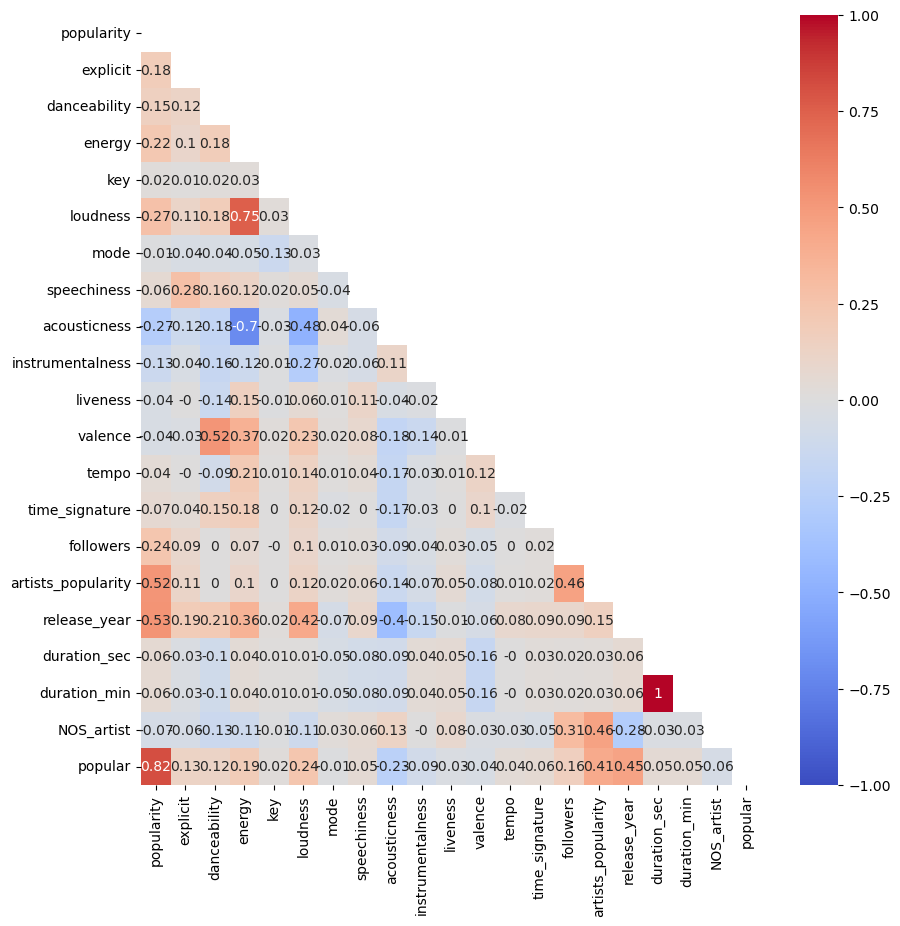

In [112]:
corr_df = df2.corr()

mask = np.triu(corr_df)

plt.figure(figsize=(10,10))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

As expected, it appears we have a strong correlation between duration_sec and duration_min (which makes sense since these are the same variable measured differently).

It appears we also have a strong positive multicolinearity between loudness and energy. Thus, we also have a strong negative correlation between acousticness and energy. So we might as well drop both loudness and acousticness since energy might measure these same characteristics in a more compreheensive way.

Also, for obvious reasons we will not use the "popularity" feature, since this is the feature we used to create our target variable "popular", this would create multicolinearity.

##### Target Variable plots 

Let's first define our target variable and our features. 

Again, we will not add duration_min, loudness, acousticness or popularity due to multicolinearity; and, we will not add categorical columns either (song_name and artist)

In [113]:
y = df2['popular']
X = df2[['duration_sec','explicit', 'danceability', 'energy', 'key', 'mode', 'speechiness', 'instrumentalness', 'liveness', 
        'valence', 'tempo', 'time_signature', 'followers', 'artists_popularity', 'release_year', 'NOS_artist']]


Now let's try plotting a boxplot and an overlaid histogram for each variable according to our target variable.

This could show us some differences and insights about the data distribution.

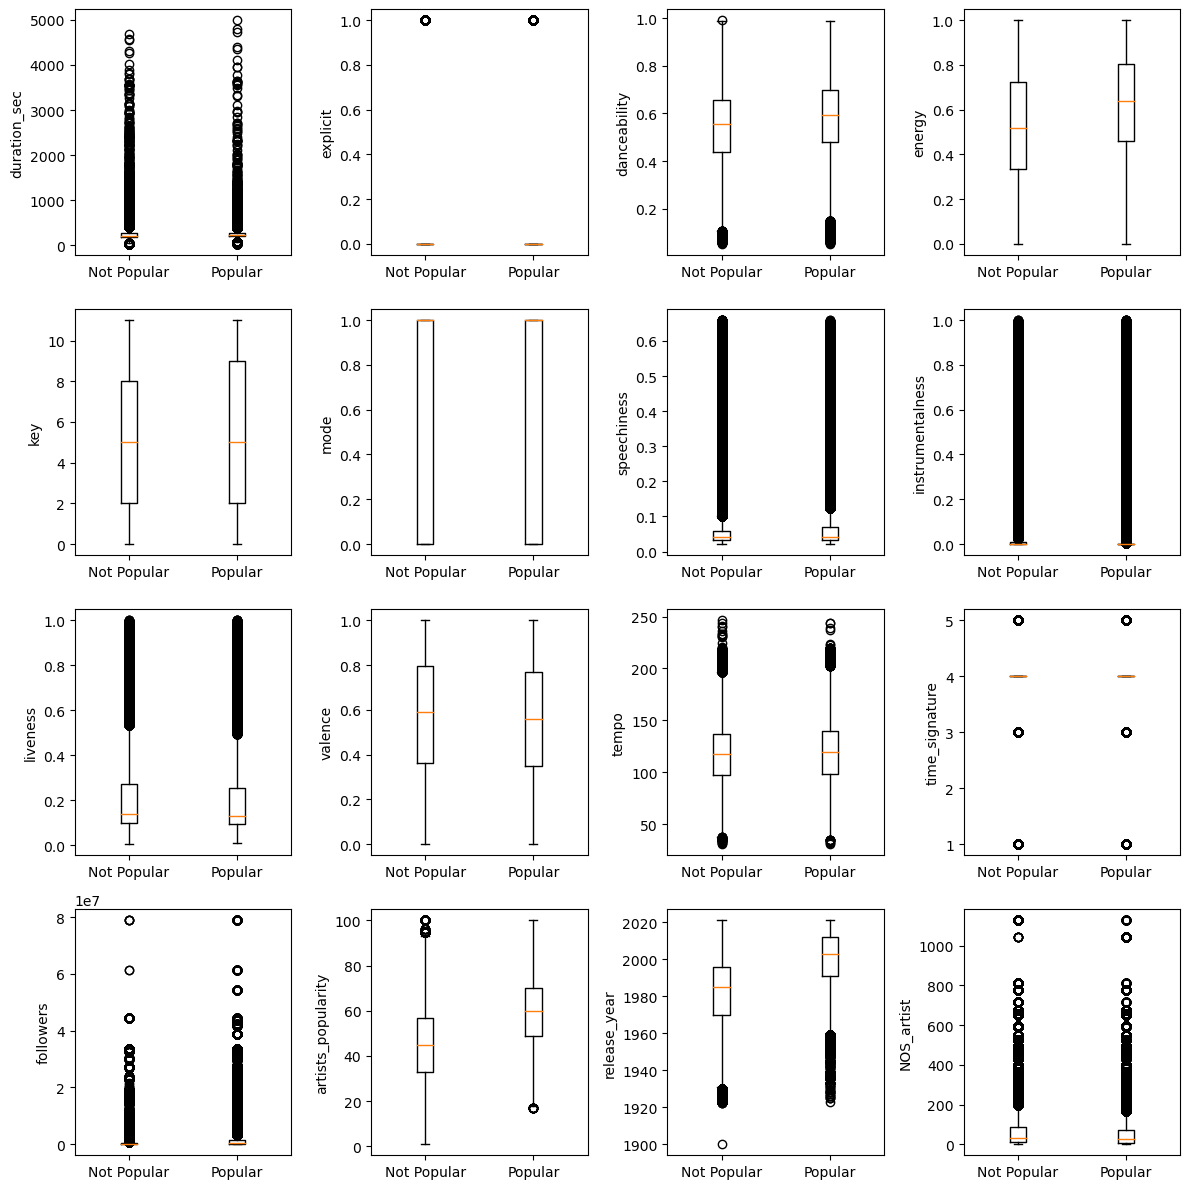

In [114]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12)) # create a 3x3 grid of subplots

for i, ax in enumerate(axes.flatten()): # loop through each subplot
    if i >= len(X.columns): 
        ax.axis('off')
        continue
    col = X.columns[i] # set the name of the columns
    ax.boxplot([X[col][y==0], X[col][y==1]])
    ax.set_xticklabels(['Not Popular', 'Popular'])
    ax.set_ylabel(col)

plt.tight_layout() 
plt.show()


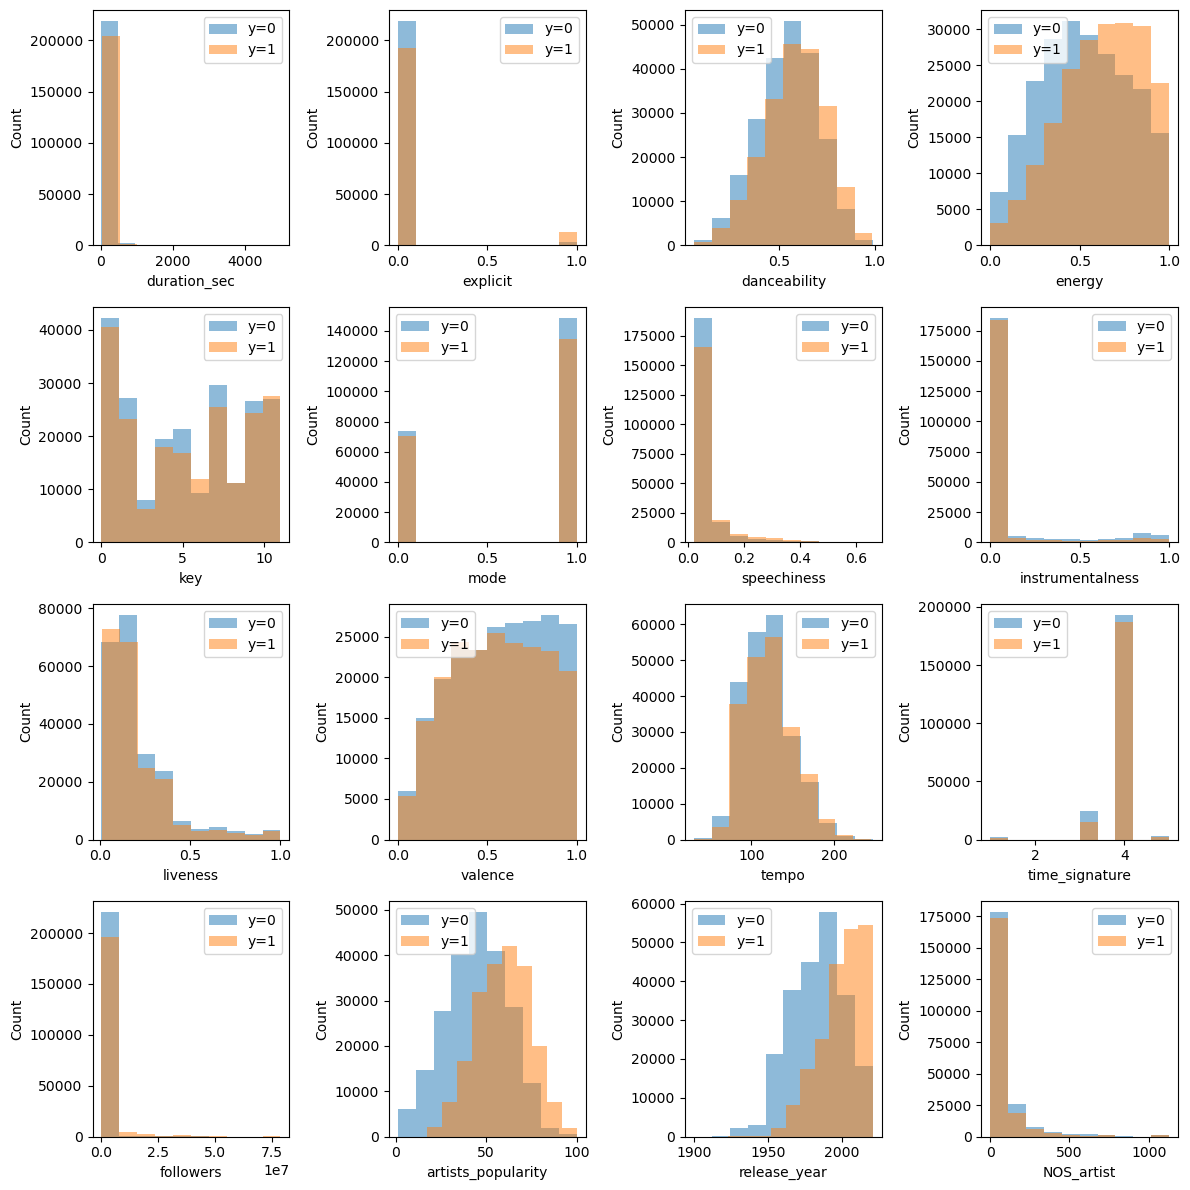

In [115]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12)) # create a 3x3 grid of subplots

for i, ax in enumerate(axes.flatten()): # loop through each subplot
    if i >= len(X.columns): 
        ax.axis('off')
        continue
    col = X.columns[i] # set the name of the current column
    ax.hist(X.loc[y==0, col], alpha=0.5, label='y=0') # plot histogram for y=0
    ax.hist(X.loc[y==1, col], alpha=0.5, label='y=1') # plot histogram for y=1
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend()

plt.tight_layout() 
plt.show()

According to our plots above Popular songs tend to have slightly higher energy, be slightly shorter and be less explicit.

However, the stronger differences we see are in artist popularity and release year.

This means that if a song was released after the 2000s it is much more likely that it could be popular. This makes sense since we have had far more resources to distribute and advertise songs/artists in more recent times.

Also, we can see that artist popularity matters. If an artist is famous they are far more likely to have popular songs. This may sound obvious, but the data confirms that in order to have a popular song there might be no clear patter in key, mode, tempo, valence, but rather there is a pattern in whether the artist is know or not. This could mean that people value artists that they already know more than specific song features.

##### Looking at P values to do feature selection

Let's take a look at our p values to see how reliable our features are. We will set a threshold of 0.05, if our p value is larger than our threshold this will mean the observation could be due to coincidence and the influence the feature has over our target variable is not reliable.

In [116]:
# Add constant to X

X_withconstant = sm.add_constant(X)

In [117]:
# instantiate model

mylogreg = sm.Logit(y, X_withconstant)

# Display summary to look at results
mylogreg_results = mylogreg.fit()
mylogreg_results.summary()

C:\Users\roant\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\roant\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\roant\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\roant\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                popular   No. Observations:               427407
Model:                          Logit   Df Residuals:                   427390
Method:                           MLE   Df Model:                           16
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                     inf
Time:                        13:53:30   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -117.0215      0.584   -200.512      0.000    -118.165    -115.878
duration_sec           0.0006   3.87e-05     16.621      0.000       0.001       0.001
explicit               0.1395      0.025      5.564      0.000       0.090       0.189
danceability           0.4460      0.032     14.004      0.000       0.384       0.508
energy                 0.0936      0.020      4.695      0.000       0.055       0.133
key                    0.0017      0.001      1.566      0.117      -0.000       0.004
mode                   0.0465      0.008      5.595      0.000       0.030       0.063
speechiness            0.2871      0.057      5.031      0.000       0.175       0.399
instrumentalness      -0.1858      0.018    -10.196      0.000      -0.222      -0.150
liveness              -0.5980      0.022    -27.175      0.000      -0.641      -0.555
valence               -0.0279      0.021     -1.341      0.180      -0.069       0.013
tempo                  0.0004      0.000      2.598      0.009    8.91e-05       0.001
time_signature         0.0203      0.010      1.949      0.051      -0.000       0.041
followers           1.064e-08   1.87e-09      5.698      0.000    6.98e-09    1.43e-08
artists_popularity     0.0790      0.000    233.632      0.000       0.078       0.080
release_year           0.0565      0.000    193.198      0.000       0.056       0.057
NOS_artist            -0.0039   4.46e-05    -86.536      0.000      -0.004      -0.004
======================================================================================
"""

It appears that we have decent P values. Except for Key, Time_signature and Valence, we should drop those and see our new p values.

In [118]:
y = df2['popular']

# Set a new X without the features with high P value

X = df2[['duration_sec','explicit', 'danceability', 'energy', 'mode', 'speechiness', 'instrumentalness', 'liveness', 
        'tempo', 'followers', 'artists_popularity', 'release_year', 'NOS_artist']]


In [119]:
# Add constant to X

X_withconstant = sm.add_constant(X)

In [120]:
# instantiate model

mylogreg = sm.Logit(y, X_withconstant)

# Display summary to look at results
mylogreg_results = mylogreg.fit()
mylogreg_results.summary()

C:\Users\roant\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\roant\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\roant\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\roant\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                popular   No. Observations:               427407
Model:                          Logit   Df Residuals:                   427393
Method:                           MLE   Df Model:                           13
Date:                Mon, 10 Apr 2023   Pseudo R-squ.:                     inf
Time:                        13:53:58   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -117.1689      0.557   -210.211      0.000    -118.261    -116.076
duration_sec           0.0007   3.83e-05     17.100      0.000       0.001       0.001
explicit               0.1418      0.025      5.663      0.000       0.093       0.191
danceability           0.4286      0.026     16.254      0.000       0.377       0.480
energy                 0.0890      0.018      4.959      0.000       0.054       0.124
mode                   0.0444      0.008      5.401      0.000       0.028       0.061
speechiness            0.2861      0.057      5.018      0.000       0.174       0.398
instrumentalness      -0.1841      0.018    -10.130      0.000      -0.220      -0.148
liveness              -0.5987      0.022    -27.215      0.000      -0.642      -0.556
tempo                  0.0003      0.000      2.356      0.018    5.46e-05       0.001
followers           1.079e-08   1.87e-09      5.779      0.000    7.13e-09    1.44e-08
artists_popularity     0.0790      0.000    234.030      0.000       0.078       0.080
release_year           0.0567      0.000    202.561      0.000       0.056       0.057
NOS_artist            -0.0039   4.46e-05    -86.647      0.000      -0.004      -0.004
======================================================================================
"""

It appears now we have chosen only features with very low p values, we should go ahead and split the data into train and test to create our models.

##### Splitting sets

We will split the dataset into train and test so we can use the train set to train our models and use the test set to test the accuracy of our models.

In [121]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

##### Scalling Data

We should also scale our data so that variables with big numbers don't have a bigger impact than variables with smaller numbers. This is important since we have many variables that are measured between 0 and 1 while other variables have no upper limit (for example, followers).

In [123]:
# scale the sets

scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train)

# scale the test 
X_test_sca = scaler.transform(X_test)

### Linear Regression<a class="anchor" id="9-bullet"></a>

Now it looks like we are ready to run our Logistic Regression model

In [124]:
logreg = LogisticRegression()

logreg.fit(X_train_sca, y_train)

# Make predictions on the test set
y_pred_log1 = logreg.predict(X_test_sca)

# Evaluate the performance of the model on the test set
accuracy = accuracy_score(y_test, y_pred_log1)

# calculate the precision
precision = precision_score(y_test, y_pred_log1)

# calculate the recall
recall = recall_score(y_test, y_pred_log1)

# calculate the f1 score
f1 = f1_score(y_test, y_pred_log1)

print("Accuracy:{:.2f}%".format(accuracy*100))
print("Precision:{:.2f}%".format(precision*100))
print("Recall:{:.2f}%".format(recall*100))
print("F1 Score:{:.2f}%".format(f1*100))

Accuracy:76.86%
Precision:75.97%
Recall:75.77%
F1 Score:75.87%


Here we simply instantiated the logistic regression model with the default hyperparameters. We can investigate what could be the best and most precise hyperparameters to improve our model and make it more precise. 

We will run a grid search to find what could be the best hyperparameters to optimize our model.

--------

In [82]:
# Instantiate
logreg = LogisticRegression()

#Set as many parameters as possible to test
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}



# Perform a 10 fold cross validation wit ha grid search
grid = GridSearchCV(logreg, param_grid=params, cv=10)
grid.fit(X_train_sca, y_train)

C:\Users\roant\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\roant\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\roant\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\roant\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\roant\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\roant\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: Us

C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

C:\Users\roant\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\roant\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\roant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

----------

In [83]:
print("Best hyperparameters: ", grid.best_params_)
print("Validation accuracy: ", grid.best_score_)

Best hyperparameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}
Validation accuracy:  0.7690604642033022


Now we'll instantiate again the model, but this time with the best hyperparameters

In [125]:
# instantiate

logreg = LogisticRegression(C=0.01, penalty='l2', solver='sag')

In [126]:
# Fit the model

logreg.fit(X_train_sca, y_train)

# Make predictions on the test set (both hard for the percentage and soft for the ROC curve plot)
y_pred_log = logreg.predict(X_test_sca)

y_pred_sft_log = logreg.predict_proba(X_test_sca)[:,1]

# Evaluate the performance of the model on the test set
accuracy = accuracy_score(y_test, y_pred_log)

# calculate the precision
precision = precision_score(y_test, y_pred_log)

# calculate the recall
recall = recall_score(y_test, y_pred_log)

# calculate the f1 score
f1 = f1_score(y_test, y_pred_log)

print("Accuracy:{:.2f}%".format(accuracy*100))
print("Precision:{:.2f}%".format(precision*100))
print("Recall:{:.2f}%".format(recall*100))
print("F1 Score:{:.2f}%".format(f1*100))

Accuracy:76.87%
Precision:75.97%
Recall:75.78%
F1 Score:75.88%


Let's also plot a confusion matrix to better visualize our results

In [127]:
y_pred_log1 = logreg.predict(X_test_sca)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_log)

# Display confusion matrix
print(cm)

[[34617  9833]
 [ 9938 31094]]


C:\Users\roant\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


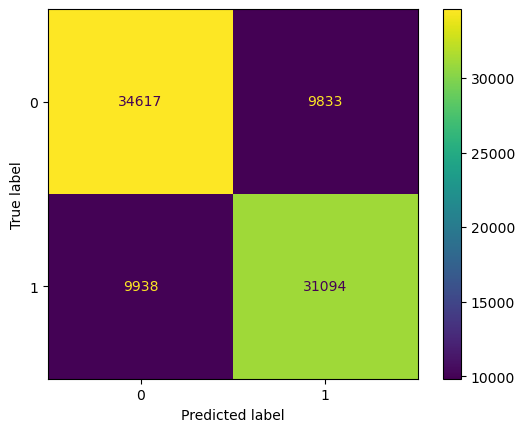

In [128]:
# Plot confusion matrix

plot_confusion_matrix(logreg, X_test_sca, y_test) # try rounding
plt.show()

It seems we have some decent results in our model. Our test accuracy was 76%. This means our model predicted the test set correctly 76% of the time. We also have 75% accuracy in both precision and recall. 

This means that, we got correctly 75% of all the values that were supposed to be positive, and also got 75% correct all the values that were predicted as positive.

Now we can take a look at our coefficients to understand the impact our variables have in our model

In [129]:
# Print out coefficients to analyze how the variables impact our model

print("Coefficients:", logreg.coef_)
print("Intercept:", logreg.intercept_)

Coefficients: [[ 0.06643436  0.02790879  0.06902423  0.02307011  0.0237695   0.01823431
  -0.038909   -0.10639813  0.01015801  0.04310143  1.40052549  1.05556407
  -0.50109268]]
Intercept: [-0.15579679]


Let's plot the result above to make it easier to understand

<Figure size 640x480 with 0 Axes>

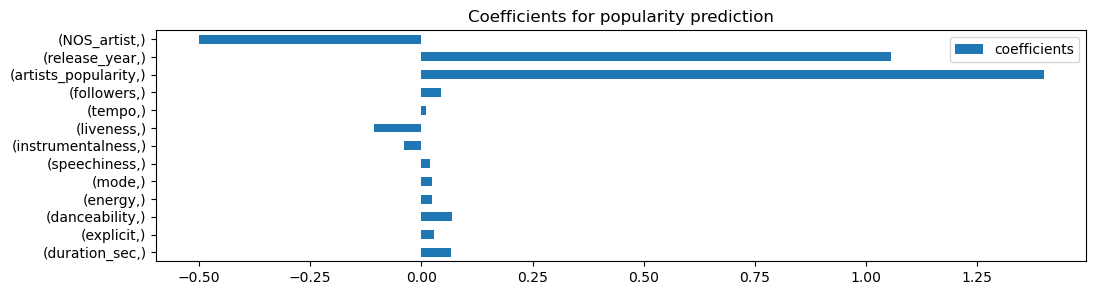

In [130]:
# Plot the result above

plt.figure()

pd.DataFrame(
    data={"coefficients": logreg.coef_.ravel()},
    index=[X.columns],
).plot(kind="barh", figsize=(12, 3), title="Coefficients for popularity prediction")

plt.show()

As we suspected before, the stronger coefficients are release_year and artists_popularity. This means that we have some features that are somewhat weak predictors on whether or not a song is popular. However, we also have some strong predictors that are very positive; this means that generaly the later the song is released, and the more famous the artist is, the more popular the song tends to be.


For NOS_artist we have a very negative coefficient, this can mean that after a certain number of songs are released by a certain artist, the odds of the next songs being popular go down. Which means that there probably is a limit to how many songs a successful artist releases. 

We should now take a look at the odds ratio to see if our interpretation of the coefficients makes sense.

In [131]:
coef = logreg.coef_[0]
names = X.columns

# calculate the odds ratios
odds_ratios = np.exp(coef)

# print the odds ratios for each feature
for name, odd in zip(names, odds_ratios):
    print(f"Odds ratio for {name}: {odd:.3f}")

Odds ratio for duration_sec: 1.069
Odds ratio for explicit: 1.028
Odds ratio for danceability: 1.071
Odds ratio for energy: 1.023
Odds ratio for mode: 1.024
Odds ratio for speechiness: 1.018
Odds ratio for instrumentalness: 0.962
Odds ratio for liveness: 0.899
Odds ratio for tempo: 1.010
Odds ratio for followers: 1.044
Odds ratio for artists_popularity: 4.057
Odds ratio for release_year: 2.874
Odds ratio for NOS_artist: 0.606


According to our odds ratio table our previous interpretation makes sense. The more we increase release year and artist popularity the more our odds of having a popular song increases. Especially if we are increasing artist popularity.

The closer the odds ratio are to 1 the worse the feature is at predicting song popularity. Our feature engineered NOS_artist has a lower value of 0.606. This could mean that the more we increase the number of songs the less likely the songs will be popular. However, this interpretation assumes a linear relation between this feature and the target variable. 

It makes much more sense that the more songs released, the more likely the songs are to become popular up until a certain number. After releasing too many songs the odds of the songs being popular actually go down, creating a non-linear relationship between NOS_artist and song popularity.

Let's also take a look at our ROC an AUC curve to evaluate the performance of our model

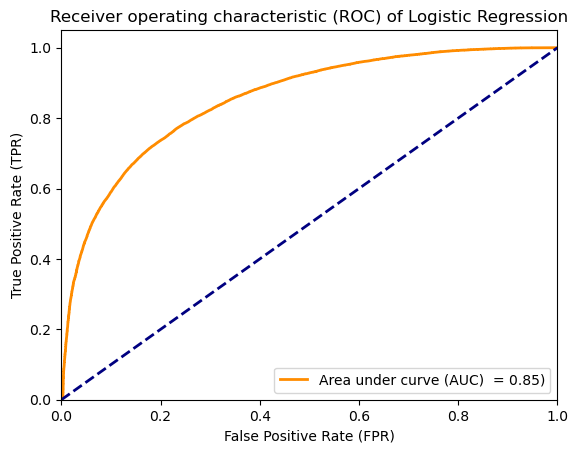

In [133]:
# define false positive and true positive rate alongside thresholds 
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_sft_log)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Area under curve (AUC)  = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver operating characteristic (ROC) of Logistic Regression')
plt.legend(loc="lower right")
plt.show()

According to the plot of our ROC and AUC our logistic regression model has a decent performance. The closer the ROC line is to the top left corner the better it is, this would mean high precision of predicting actual popular songs while low mistakes of predicting unpopular songs as popular.

Generally we want the area under the curve to be as close to 1 as possible and as far away to 0.5 as possible. A value of 0.5 for AUC  would mean our model performs as accurately as a coin toss.

Since our target variable is binary, a decision tree classifier model should work efficiently at accurately predicting the outcome of 0 or 1, or in this case, popular song or unpopular song. Let's try that model next.

### Decision Tree Classifier<a class="anchor" id="5-bullet"></a>

Now let's try to run a decision Tree model with a random max_depth. Keeping in mind that since this is a Decision Tree model we do not need to use our scaled data.

In [134]:
dtc = DecisionTreeClassifier(random_state=17, max_depth=10)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=17)

In [135]:
y_pred_dtc = dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dtc)
print("Accuracy:", accuracy)

Accuracy: 0.8132004398586837


We got 81% accuracy with some default hyperparameters and a max_depth of 10, let's try to test a few values to optimize our model.

In [246]:
params = {'max_depth': [2, 5, 10, 15, 30, 50, 100],
          'min_samples_split': [2, 5, 10, 50, 100, 200], 
          'min_samples_leaf': [1, 5, 50, 100, 200],
          'criterion': ['gini', 'entropy']
         }
          
          
grid = GridSearchCV(dtc, param_grid=params, cv=10)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 200}


Now let's run our Decision Tree model with the hyperparameters we found

In [136]:
dtc = DecisionTreeClassifier(random_state=17, max_depth=15, criterion='entropy', min_samples_leaf= 5, min_samples_split=200)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       min_samples_split=200, random_state=17)

In [137]:
y_pred_dtc = dtc.predict(X_test)

y_pred_sft_dtc = dtc.predict_proba(X_test)[:,1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_dtc)

# calculate the precision
precision = precision_score(y_test, y_pred_dtc)

# calculate the recall
recall = recall_score(y_test, y_pred_dtc)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_dtc)

print("Accuracy:{:.2f}%".format(accuracy*100))
print("Precision:{:.2f}%".format(precision*100))
print("Recall:{:.2f}%".format(recall*100))
print("F1 Score:{:.2f}%".format(f1*100))

Accuracy:81.35%
Precision:81.09%
Recall:79.73%
F1 Score:80.41%


C:\Users\roant\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


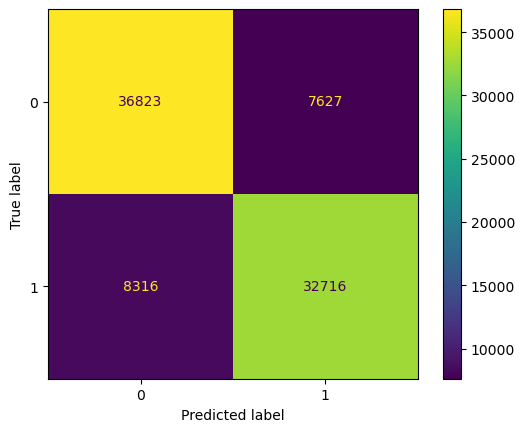

In [138]:
plot_confusion_matrix(dtc, X_test, y_test)
plt.show()

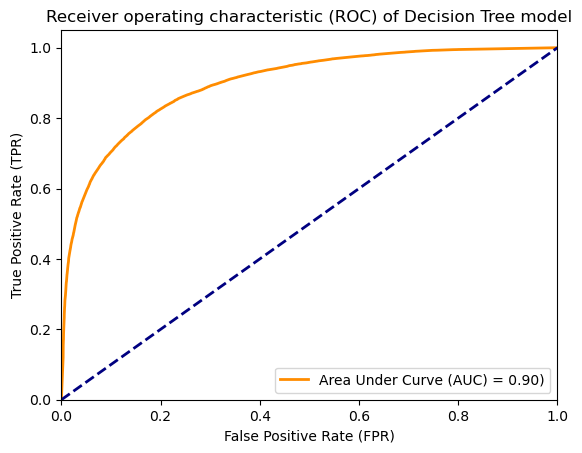

In [139]:
# define false positive and true positive rate alongside thresholds
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_sft_dtc)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='Area Under Curve (AUC) = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver operating characteristic (ROC) of Decision Tree model')
plt.legend(loc="lower right")
plt.show()

Using the same metrics we used for logistic regression, we can tell that our decision tree classifier is performing better. We had an increase in every single metric: accuracy, precision, recall, F1 and ROC/AUC. This means that this model is not only better at accurately preicting which songs are popular but also it is making fewer mistakes (misclassifying less unpopular songs as popular).

Since we had such good results with decision tree classifier we might as well try random forest next. The random forest model is a model that combines several different decision trees to create a final model from the average of the several different decision trees together.

### Random Forest<a class="anchor" id="8-bullet"></a>

In [140]:
# intantiate and fit the model
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [141]:
# create prediction
y_pred_rf = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)

In [148]:
print("Accuracy:{:.2f}%".format(accuracy*100))

# calculate the precision
precision = precision_score(y_test, y_pred_rf)

y_pred_sft_rf = rf.predict_proba(X_test)[:,1]

# calculate the recall
recall = recall_score(y_test, y_pred_rf)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_rf)

print("Precision:{:.2f}%".format(precision*100))
print("Recall:{:.2f}%".format(recall*100))
print("F1 Score:{:.2f}%".format(f1*100))

Accuracy:82.63%
Precision:83.38%
Recall:79.70%
F1 Score:81.50%


We had some great results. Unfortunately, random forest is very computationally intensive and running a grid search with it might take way too long and not actually improve our accuracy metrics by a lot, so we will not perform a grid search for this model.

C:\Users\roant\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


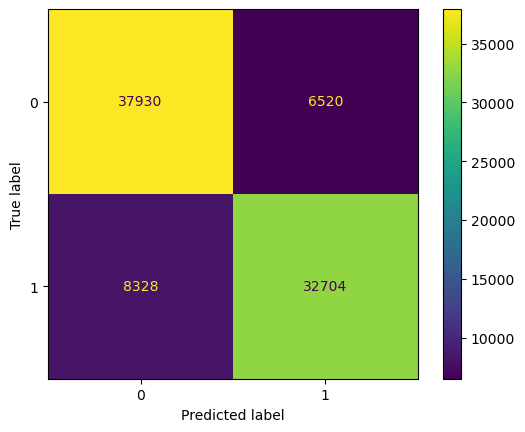

In [149]:
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

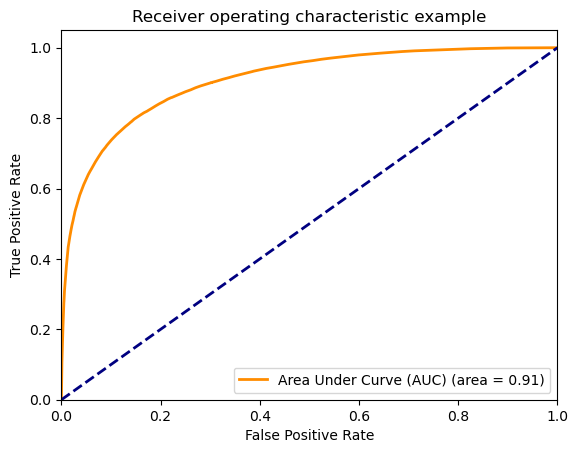

In [150]:
# define false positive and true positive rate alongside thresholds
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_sft_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Area Under Curve (AUC) (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

As expected, our random forest was our best performing model. In almost every single metric tested (accuracy, precision, F1 and AUC/ROC). It performed better than the other two models, making this the best model not only at predicting how likely a song is to be popular but also at not misjudging when an unpopular song is popular.

The only metric our random forest did not perform better than our decision tree was recall, which we got pretty much the same result.

We can finally plot our results so we can compare them side by side across our different models.

### Models Results<a class="anchor" id="10-bullet"></a>

We can now plot our metrics to better visualize and compare our models

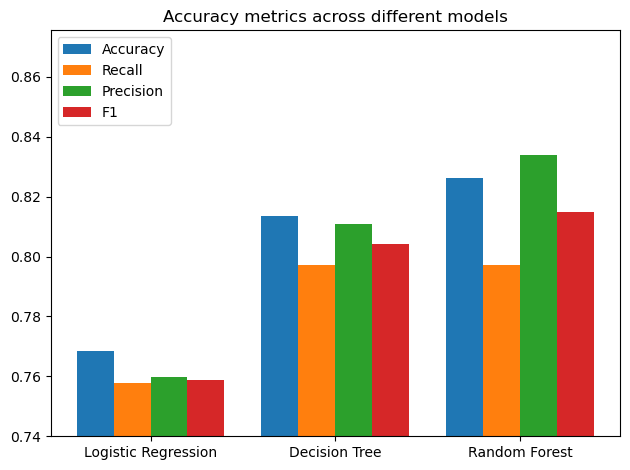

In [151]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracy = [0.7686, 0.8135, 0.8263] 
recall = [0.7578, 0.7973, 0.7970]
precision = [0.7597, 0.8109, 0.8338]
f1 = [0.7588, 0.8041, 0.8150]
    

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, recall, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, precision, width, label='Precision')
rects4 = ax.bar(x + 1.5*width, f1, width, label='F1')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='upper left')
ax.set_ylim(bottom=0.74)
plt.title('Accuracy metrics across different models')

fig.tight_layout()
plt.show()

We can also plot our ROC/AUC curves to have another way to visualize and compare our models

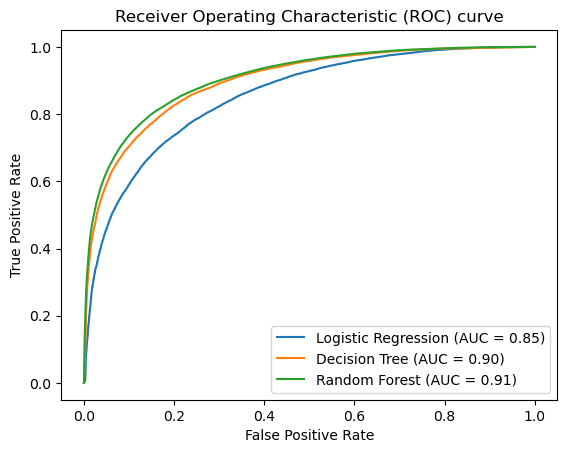

In [152]:
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Add legend, title and axis labels
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

Plotting together our ROC + AUC values of our 3 models we can see that our decision tree was almost as good as the random forest, but the latter was still the best model. Our logistic regression model was our worst performing model, even though it is a great model to start with and a simple model in which we can understand how the effect the features are having in the model.

### Conclusion<a class="anchor" id="7-bullet"></a>

In conclusion, predicting song popularity is no easy task. We have a lot of variables that account for a song becomig popular, and often, it may just be due to randomness. Nevertheless, we managed to run a thorough analysis on this issue, finding several key points and creating models that are fairly accurate at predicting if a song is popular or not.

To summarise:
- Popular songs tend to have higher energy, be less explicit and last between 2 to 6 minutes
- Not necessarily the artist with most followers on Spotify scores higher on Artist Popularity
- Songs released after the 2000s have a much higher tendency to become popular
- Artist popularity matters, people view songs as popular if they were composed by artists they already know
- With an accuracy of about 83% a random forest model was our best performing model

Thus, we can use this model to try and predict song popularity for new songs using new datasets.